<a href="https://colab.research.google.com/github/Debbie2810/Retail-Analytics---Customer-Purchase-Behavior/blob/main/Capstone_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Project Title: Retail Sales Analytics for Predictive Insights & Business Recommendations

---

#### Domain Use Cases:
Retail analytics plays a pivotal role in the modern retail industry, offering insights to enhance business operations and customer satisfaction. Key use cases include:

- **Sales Forecasting**: Predicting future sales based on historical data to optimize inventory management.
- **Markdown Optimization**: Analyzing the impact of discounts on sales and profitability.
- **Customer Insights**: Understanding customer behavior patterns to tailor marketing strategies.
- **Demand Forecasting**: Predicting demand for products across different store locations and seasons.
- **Operational Efficiency**: Analyzing factors such as CPI, unemployment rates, and store performance to improve overall business processes.

---

#### Synopsis:
This project focuses on analyzing retail sales data to uncover insights that can drive business decision-making and enhance operational efficiency. Using a dataset sourced from Kaggle, which spans from February 2010 to November 2012, the analysis aims to:

1. Predict weekly sales for various departments across 45 stores.
2. Understand the impact of markdowns and economic factors like fuel prices and unemployment on sales.
3. Provide actionable business recommendations based on the findings.

The project includes data cleaning, exploratory data analysis (EDA), and building predictive models to support retail business strategies.



### Dataset Description

This project uses the **Retail Data Analytics** dataset, sourced from Kaggle, which contains historical sales data from 45 stores across various regions. The data includes:

- **Stores:** Anonymized information on store types and sizes.
- **Features:** Data on temperature, fuel prices, markdowns, CPI, unemployment, and holiday indicators.
- **Sales:** Weekly sales data by store and department, along with holiday information.

The dataset spans from February 2010 to November 2012 and is used to predict department-wide sales, analyze markdown impacts, and provide business recommendations.

**Kaggle URL:** [Retail Data Analytics](https://www.kaggle.com/datasets/manjeetsingh/retaildataset/data)

### 1. **Import Libraries**
Set up the environment for a data analysis project by importing essential libraries and functions. These libraries are pivotal for various tasks, such as data manipulation (`Pandas`), numerical operations (`NumPy`), data visualization (`Matplotlib` & `Seaborn`), and time series analysis (`Statsmodels` and `SciPy`).

With these imports, the code prepares for further operations such as loading datasets, performing statistical analysis, and creating visualizations based on that data.

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. **Load CSV Files with Error Handling**
The function `load_csv()` is used to load CSV files while ensuring the files exist. Three files (`stores`, `features`, `sales`) are loaded, and any errors in loading are handled gracefully.


In [ ]:
# Load CSV files with error handling
def load_csv(filename):
    """Load a CSV file and return its DataFrame; raises FileNotFoundError if the file does not exist."""
    if not os.path.exists(filename):
        raise FileNotFoundError(f"The file {filename} does not exist.")
    return pd.read_csv(filename)

# Load datasets with error handling
file_names = ['/content/drive/MyDrive/Colab Notebooks/Great Learning - Capstone/stores data-set.csv', '/content/drive/MyDrive/Colab Notebooks/Great Learning - Capstone/Features data set.csv', '/content/drive/MyDrive/Colab Notebooks/Great Learning - Capstone/sales data-set.csv']
try:
    stores_df, features_df, sales_df = map(load_csv, file_names)
except FileNotFoundError as e:
    print(e)
    exit()

### 3. **Data Cleaning & Preprocessing**
- **Convert 'Date' Columns**: The code ensures that the 'Date' column is converted into a `datetime` format to facilitate merging.
- **Merging**: The datasets are merged using the columns `Store` and `Date` to form the final dataset.
- **Missing Values**: The code checks for missing values and drops columns with more than 25% missing values. For remaining missing data, it uses forward-fill for categorical columns and median for numerical columns.

In [ ]:
# Ensure 'Date' columns are in datetime format for merging
try:
    for df in (features_df, sales_df):
        """Convert 'Date' columns to datetime format."""
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
except ValueError as e:
    print(f"Error converting 'Date' column: {e}")
    exit()

# Merge datasets on Store and Date with error handling
try:
    """Merge sales, features, and stores datasets into a final DataFrame."""
    final_df = sales_df.merge(features_df, on=['Store', 'Date'], how='left').merge(stores_df, on='Store', how='left')
except KeyError as e:
    print(f"Error during merging: {e}")
    exit()

# Check for missing required columns and raise an error if any are missing
required_columns = ['Date', 'Store', 'Dept', 'Weekly_Sales']
missing_columns = set(required_columns) - set(final_df.columns)
if missing_columns:
    """Raise an error if required columns are missing in the final DataFrame."""
    raise KeyError(f"The following required columns are missing: {missing_columns}")

### 4. **Handling Missing Rows in Essential Columns**
The code verifies whether essential columns (`store`, `department`, `date`) exist and drops rows where more than 25% values are missing.

In [ ]:
print("\nMissing values per column before cleaning:")
print(final_df.isnull().sum())


Missing values per column before cleaning:
Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
Type                 0
Size                 0
dtype: int64


In [ ]:
# Define a 25% missing value threshold for each column and drop columns as necessary
threshold = 0.25 * final_df.shape[0]
cols_to_drop = final_df.columns[final_df.isnull().sum() > threshold]
print(f"\nColumns with more than 25% missing values will be dropped: {cols_to_drop.tolist()}")
final_df.drop(columns=cols_to_drop, inplace=True)

# Handle missing values for remaining columns
for col in final_df.columns:
    """Fill missing values based on the column type."""
    if final_df[col].dtype == 'object':
        final_df[col] = final_df[col].ffill()  # Forward fill for categorical data
    else:
        final_df[col] = final_df[col].fillna(final_df[col].median())  # Fill NaN with median


Columns with more than 25% missing values will be dropped: ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']


In [ ]:
print("\nMissing values per column after cleaning:")
print(final_df.isnull().sum())


Missing values per column after cleaning:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday_x     0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
IsHoliday_y     0
Type            0
Size            0
dtype: int64


### 5. **Data Export**
After cleaning, the dataset is saved into a CSV file `cleaned_final_combined_dataset.csv`. The code also exports a final version as `final_combined_dataset.csv` for further analysis.

In [ ]:
# Check and drop rows with missing values in essential columns
essential_columns = ['store', 'department', 'date']
if all(col in final_df.columns for col in essential_columns):
    rows_to_drop = final_df[essential_columns].isnull().mean(axis=1) > 0.25
    if rows_to_drop.any():
        """Drop rows where more than 25% values are missing."""
        print(f"\nDropping {rows_to_drop.sum()} rows where more than 25% values are missing.")
        final_df = final_df[~rows_to_drop]
    else:
        print("\nNo rows to drop based on the missing value criteria.")
else:
    print(f"Essential columns missing from the DataFrame: {set(essential_columns) - set(final_df.columns)}")

print("\nDataset shape after cleaning:", final_df.shape)

# Export the cleaned dataset to a new CSV file with error handling
output_cleaned_filename = "cleaned_final_combined_dataset.csv"
try:
  """Export the cleaned DataFrame to a new CSV file."""
  final_df.to_csv(output_cleaned_filename, index=False)
  print(f"Cleaned final combined dataset exported successfully to '{output_cleaned_filename}'.")
except Exception as e:
  print(f"Error exporting cleaned dataset to CSV: {e}")

Essential columns missing from the DataFrame: {'date', 'store', 'department'}

Dataset shape after cleaning: (421570, 12)
Cleaned final combined dataset exported successfully to 'cleaned_final_combined_dataset.csv'.


### 6. **Exploratory Data Analysis (EDA)**
- **Descriptive Statistics**: Summarizes the final cleaned dataset using `describe()` and checks for column data types.
- **Sales Distribution**: Displays percentiles (25th, 50th, 75th) of sales, and plots the distribution using histograms and box plots.

In [ ]:
# Rearrange columns and rename them
final_df = final_df[required_columns + [col for col in final_df.columns if col not in required_columns]].rename(columns={
  'Date': 'date',
  'Store': 'store',
  'Dept': 'department',
  'Weekly_Sales': 'sales'
})

# Convert sales to numeric, forcing errors to NaN
"""Convert the 'sales' column to numeric data type, converting non-numeric entries to NaN."""
final_df['sales'] = pd.to_numeric(final_df['sales'], errors='coerce')

# Display final dataframe and its summary
print("\n", final_df.head())
print("\n", final_df.info())
print("\n", final_df.describe())

# Export the final dataset with error handling
output_filename = "final_combined_dataset.csv"
try:
  """Export the final DataFrame to a CSV file."""
  final_df.to_csv(output_filename, index=False)
  print(f"\nFinal combined dataset exported successfully to '{output_filename}'.")
except Exception as e:
  print(f"\nError exporting to CSV: {e}")



         date  store  department     sales  IsHoliday_x  Temperature  \
0 2010-02-05      1           1  24924.50        False        42.31   
1 2010-02-12      1           1  46039.49         True        38.51   
2 2010-02-19      1           1  41595.55        False        39.93   
3 2010-02-26      1           1  19403.54        False        46.63   
4 2010-03-05      1           1  21827.90        False        46.50   

   Fuel_Price         CPI  Unemployment  IsHoliday_y Type    Size  
0       2.572  211.096358         8.106        False    A  151315  
1       2.548  211.242170         8.106         True    A  151315  
2       2.514  211.289143         8.106        False    A  151315  
3       2.561  211.319643         8.106        False    A  151315  
4       2.625  211.350143         8.106        False    A  151315  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
-

Calculate & Visualize the Distribution of the Sales Data:

The code first checks if the `sales` column has valid data, then computes the 25th, 50th, and 75th percentiles of the sales values using NumPy. Following the calculation, it prints these percentiles in an easily understandable format.

Further, it visualizes the sales distribution through a histogram and a box plot to provide insights into the data's central tendency and dispersion, along with potential outliers. If no sales data is present, it gracefully informs the user of the absence of data for analysis.


Percentiles of sales:
25th percentile: 2079.65
50th percentile: 7612.03
75th percentile: 20205.85


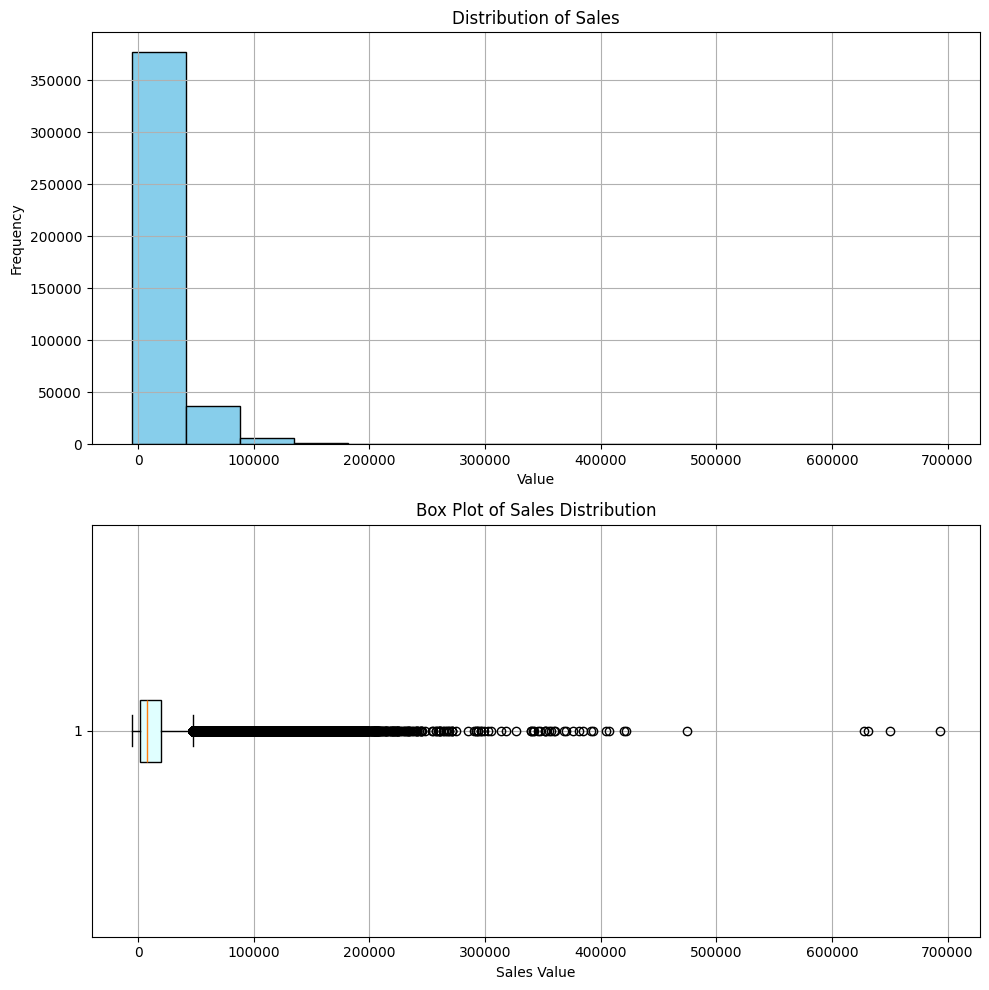

In [ ]:
# Calculate and visualize percentiles
if not final_df['sales'].empty:
  """Calculate and display percentiles of the sales data."""
  perc_values = np.percentile(final_df['sales'].dropna(), [25, 50, 75])
  print('\nPercentiles of sales:')
  for p, v in zip([25, 50, 75], perc_values):
    print(f'{p}th percentile: {v:.2f}')

  # Visualization of sales distribution
  fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

  # Histogram
  axs[0].hist(final_df['sales'].dropna(), bins=15, color='skyblue', edgecolor='black')
  axs[0].set(xlabel='Value', ylabel='Frequency', title='Distribution of Sales')
  axs[0].grid()

  # Box Plot
  axs[1].boxplot(final_df['sales'].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightcyan', edgecolor='black'))
  axs[1].set(xlabel='Sales Value', title='Box Plot of Sales Distribution')
  axs[1].grid()

  plt.tight_layout()
  plt.show()
else:
  print("\nNo sales data available for percentile calculation.")

### 7. **Time Series Analysis**
- **Date Transformations**: The dataset is further prepared for time series analysis by adding columns for `year`, `month`, and `week`.
- **Sales Trends**: Yearly and weekly sales are plotted to understand sales trends over time.

Analyze Sales Data Over Time:

1. **Data Loading**: It loads a dataset and converts its date column to a datetime format.
2. **Timeframe Calculation**: It determines the range of dates in the dataset.
3. **Temporal Features Creation**: It creates new columns for the year, month, and week from the date.
4. **Sales Aggregation**: It groups sales data by year to compute total yearly sales.
5. **Visualization**: It plots the average weekly sales for each year, providing insights into sales trends over time.

In [ ]:
final_df.columns.str.strip()

Index(['date', 'store', 'department', 'sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size'],
      dtype='object')


Timeframe of the data: 2010-02-05 00:00:00 to 2012-10-26 00:00:00


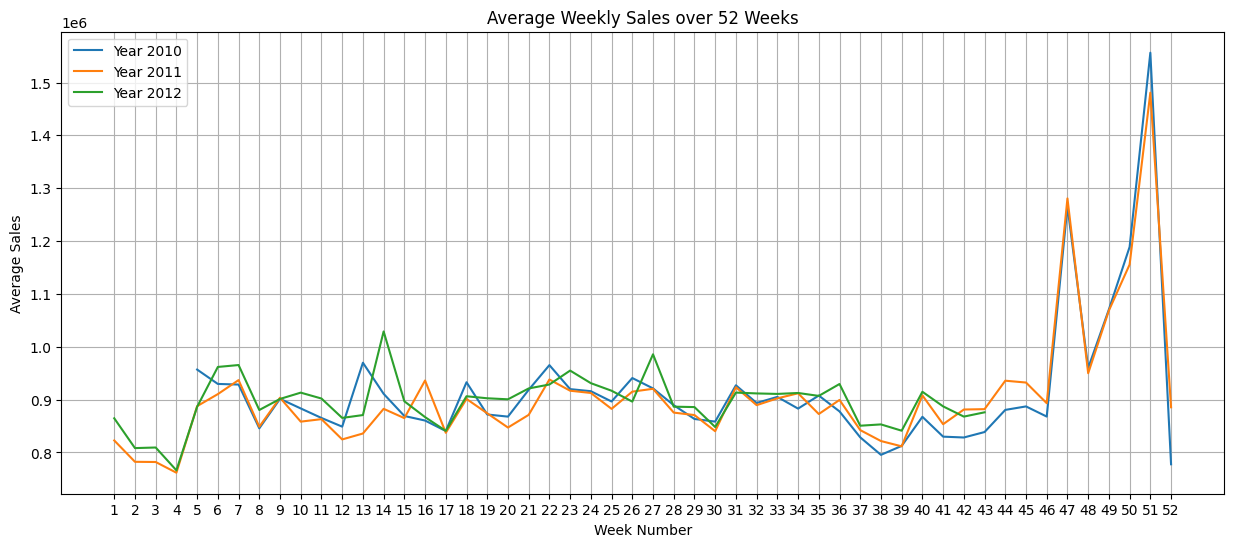

In [ ]:
# Loading the exported dataset for further analysis
try:
  """Load the exported dataset for further analysis."""
  data = pd.read_csv(output_filename)
  data['date'] = pd.to_datetime(data['date'])
except Exception as e:
  print(f"Error loading the exported dataset: {e}")
  exit()

# Total timeframe of the dataset
start_date, end_date = data['date'].min(), data['date'].max()
print(f"\nTimeframe of the data: {start_date} to {end_date}")

# Create columns for sales year, month, and week efficiently
data[['year', 'month', 'week']] = data['date'].apply(lambda x: pd.Series([x.year, x.month, x.isocalendar().week]))

# Group by year for sales totals
"""Group sales data by year to calculate yearly sales totals."""
yearly_sales = data.groupby('year')['sales'].sum()

# Plot average weekly sales for each year
plt.figure(figsize=(15, 6))
for year in yearly_sales.index:
  """Plot average weekly sales for each year."""
  avg_sales = data[data['year'] == year].groupby('week')['sales'].sum() / 52
  plt.plot(avg_sales.index, avg_sales, label=f'Year {year}')
plt.title('Average Weekly Sales over 52 Weeks')
plt.xlabel('Week Number')
plt.ylabel('Average Sales')
plt.legend()
plt.grid()
plt.xticks(range(1, 53))
plt.show()

### 8. **Monthly Sales & Yearly Trends**
- **FacetGrid**: A FacetGrid plot is created for each year's monthly sales trends. This helps compare year-on-year trends.

Visualize Monthly Sales Data Over Several Years:

First aggregate the sales data by year and month, creating a structured summary. Using Seaborn's FacetGrid, the code generates a series of line plots that illustrate the sales trends for each year, allowing for easy comparison across different time periods. Each subplot is annotated with total sales figures in millions, providing clarity on the monthly performance.

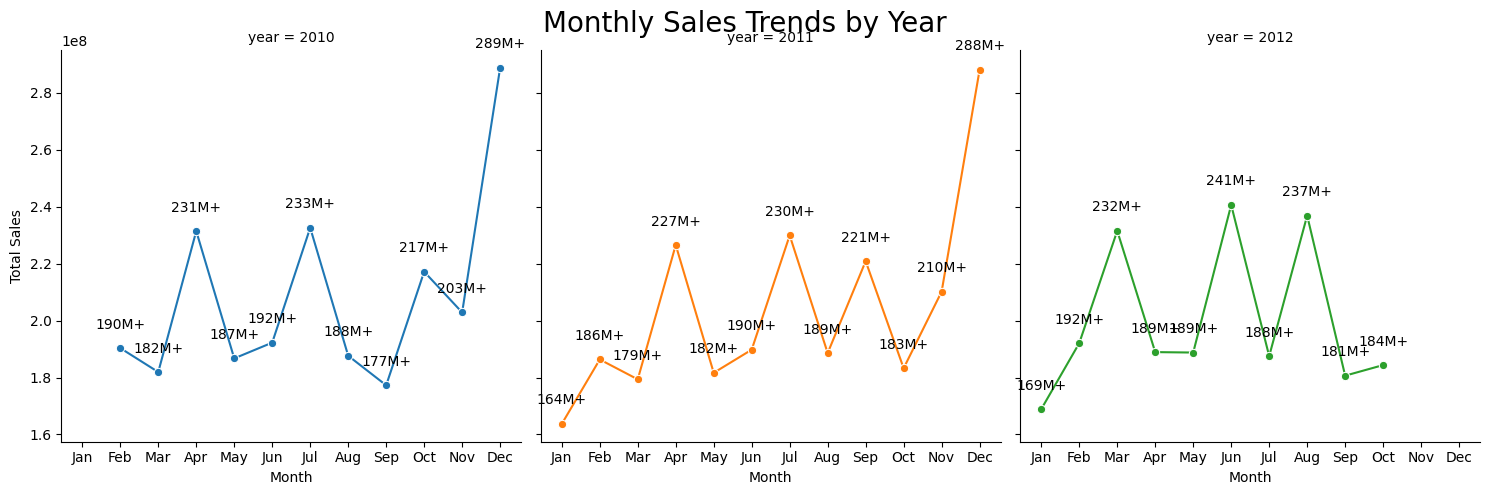

In [ ]:
# Create monthly sales summary
"""Create a DataFrame summarizing monthly sales."""
monthly_sales = data.groupby(['year', 'month'])['sales'].sum().reset_index(name='sales')
monthly_sales['year_month'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))

# Create a FacetGrid for each year
g = sns.FacetGrid(monthly_sales, col='year', hue='year', sharey=True, height=5)
g.map(sns.lineplot, 'month', 'sales', marker='o')
for ax in g.axes.flat:
  for i, row in monthly_sales[monthly_sales['year'] == int(ax.get_title().split('=')[1].strip())].iterrows():
    ax.text(row['month'], row['sales'] + 0.02 * monthly_sales['sales'].max(), f"{row['sales'] / 1_000_000:.0f}M+", fontsize=10, ha='center', va='bottom')

  ax.set_xticks(range(1, 13))
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Monthly Sales Trends by Year', fontsize=20)
g.set_axis_labels("Month", "Total Sales")
plt.show()

### 9. **Sales by Store & Department**
- **Violin Plot**: A violin plot shows the distribution of sales by stores, while a bar chart shows total sales by department.
- **Top Departments by Sales**: The code identifies the top 10 departments by total sales and visualizes them in a horizontal bar plot

Generate a combined violin and box plot that visually represents the distribution of sales across different stores. The violin plot illustrates the density of sales data for each store, while the box plot overlays to highlight the key statistics such as quartiles.

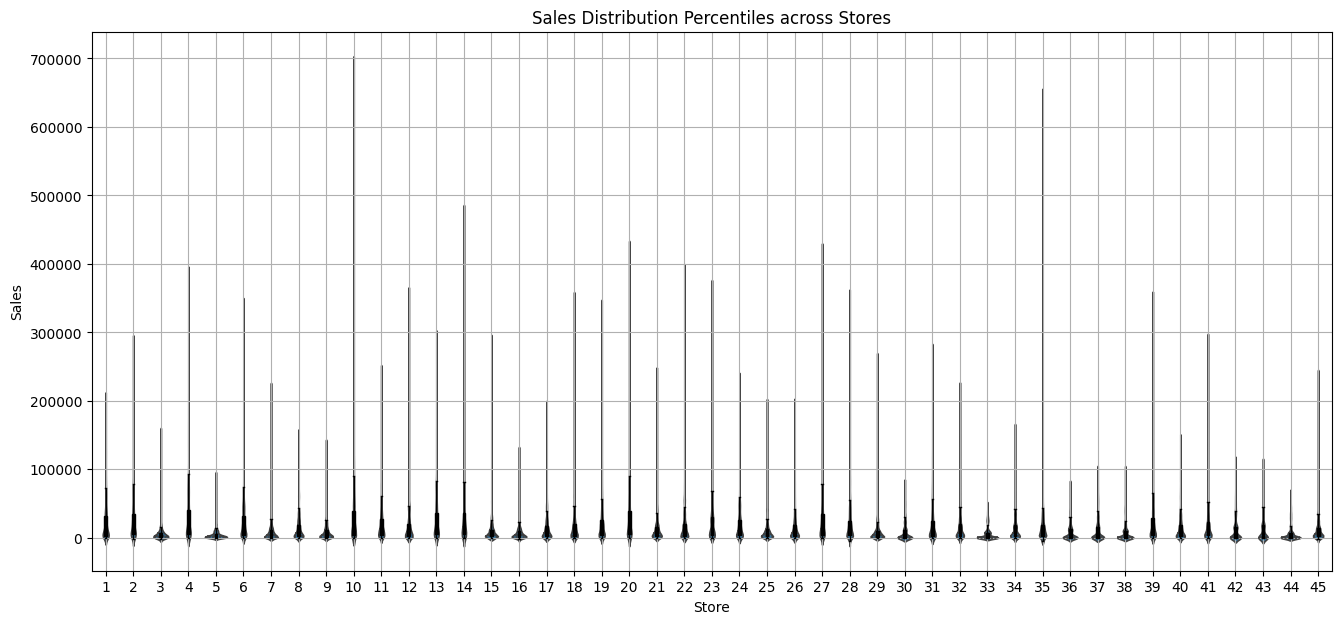

In [ ]:
# Create a violin plot for sales distribution by store
plt.figure(figsize=(16, 7))
sns.violinplot(x='store', y='sales', data=data, inner='quartile')
sns.boxplot(x='store', y='sales', data=data, width=0.1, color='k', fliersize=0)
plt.title('Sales Distribution Percentiles across Stores')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.grid()
plt.show()

Analyze the sales data by calculating & displaying the number of unique stores and departments in the dataset:

The code subsequently computes the total and average weekly sales for each store and department using the Pandas library. Finally, it consolidates and prints the summary results, providing insights into the performance of different stores and departments within the sales context.

In [ ]:
# Analyze unique stores and departments
"""Analyze and print the number of unique stores and departments."""
num_stores = stores_df['Store'].nunique()
num_departments = sales_df['Dept'].nunique()
print(f"Number of unique stores: {num_stores}")
print(f"Number of unique departments: {num_departments}")

# Calculate sum and average sales for each store and department
"""Calculate total and average sales for each store and each department."""
store_summary = sales_df.groupby('Store')['Weekly_Sales'].agg(['sum', 'mean']).reset_index().rename(columns={
  'sum': 'Total_Sales', 'mean': 'Average_Sales'
})
dept_summary = sales_df.groupby('Dept')['Weekly_Sales'].agg(['sum', 'mean']).reset_index().rename(columns={
  'sum': 'Total_Sales', 'mean': 'Average_Sales'
})

# Display the results
print("\nSales Summary by Store and Department:")
print(pd.concat([store_summary, dept_summary.rename(columns={"Dept": "Store"})], ignore_index=True))

Number of unique stores: 45
Number of unique departments: 81

Sales Summary by Store and Department:
     Store   Total_Sales  Average_Sales
0        1  2.224028e+08   21710.543621
1        2  2.753824e+08   26898.070031
2        3  5.758674e+07    6373.033983
3        4  2.995440e+08   29161.210415
4        5  4.547569e+07    5053.415813
..     ...           ...            ...
121     95  4.493202e+08   69824.423080
122     96  7.383392e+07   15210.942761
123     97  8.949651e+07   14255.576919
124     98  3.982892e+07    6824.694889
125     99  3.581498e+05     415.487065

[126 rows x 3 columns]


Display total sales for each store, allowing for quick comparisons of store performance:

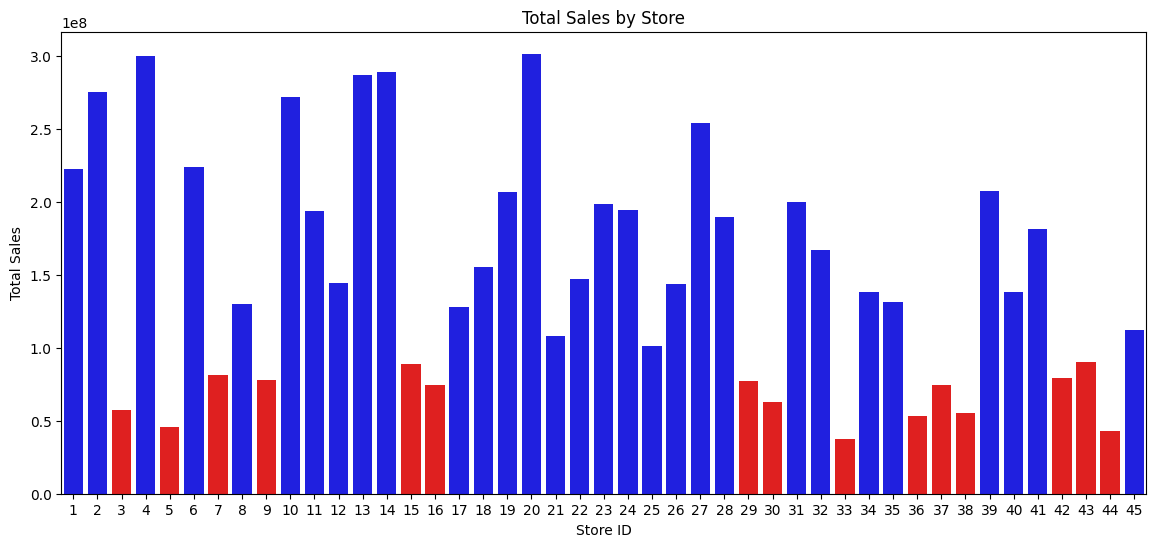

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column to categorize store sales
store_summary['Sales_Category'] = store_summary['Total_Sales'].apply(lambda x: 'Low' if x < 1e8 else 'High')

# Create the bar plot with conditional coloring (without legend)
plt.figure(figsize=(14, 6))
sns.barplot(x='Store', y='Total_Sales', hue='Sales_Category', data=store_summary,
            palette={'Low': 'red', 'High': 'blue'}, dodge=False, legend=False)

# Titles and labels
plt.title('Total Sales by Store')
plt.xlabel('Store ID')
plt.ylabel('Total Sales')

# Show the plot
plt.show()


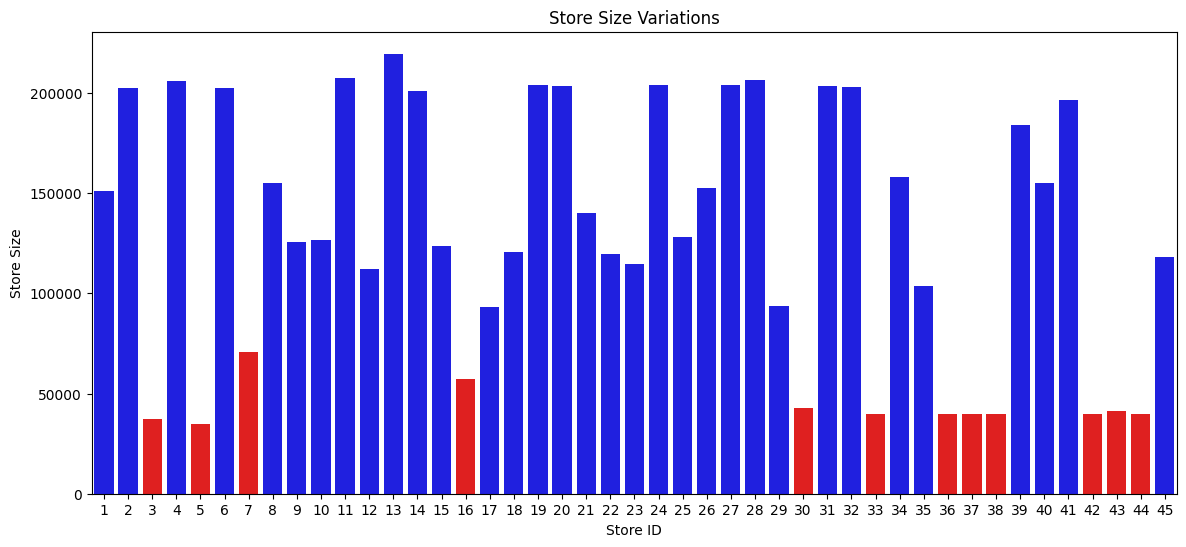

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column to categorize store sizes
final_df['Size_Category'] = final_df['Size'].apply(lambda x: 'Small' if x < 75000 else 'Large')

# Create the bar plot with conditional coloring (without legend)
plt.figure(figsize=(14, 6))
sns.barplot(x='store', y='Size', hue='Size_Category', data=final_df,
            palette={'Small': 'red', 'Large': 'blue'}, dodge=False, legend=False)

# Titles and labels
plt.title('Store Size Variations')
plt.xlabel('Store ID')
plt.ylabel('Store Size')

# Show the plot
plt.show()


Present total sales classified by department, helping to analyze which departments contribute most significantly to sales:

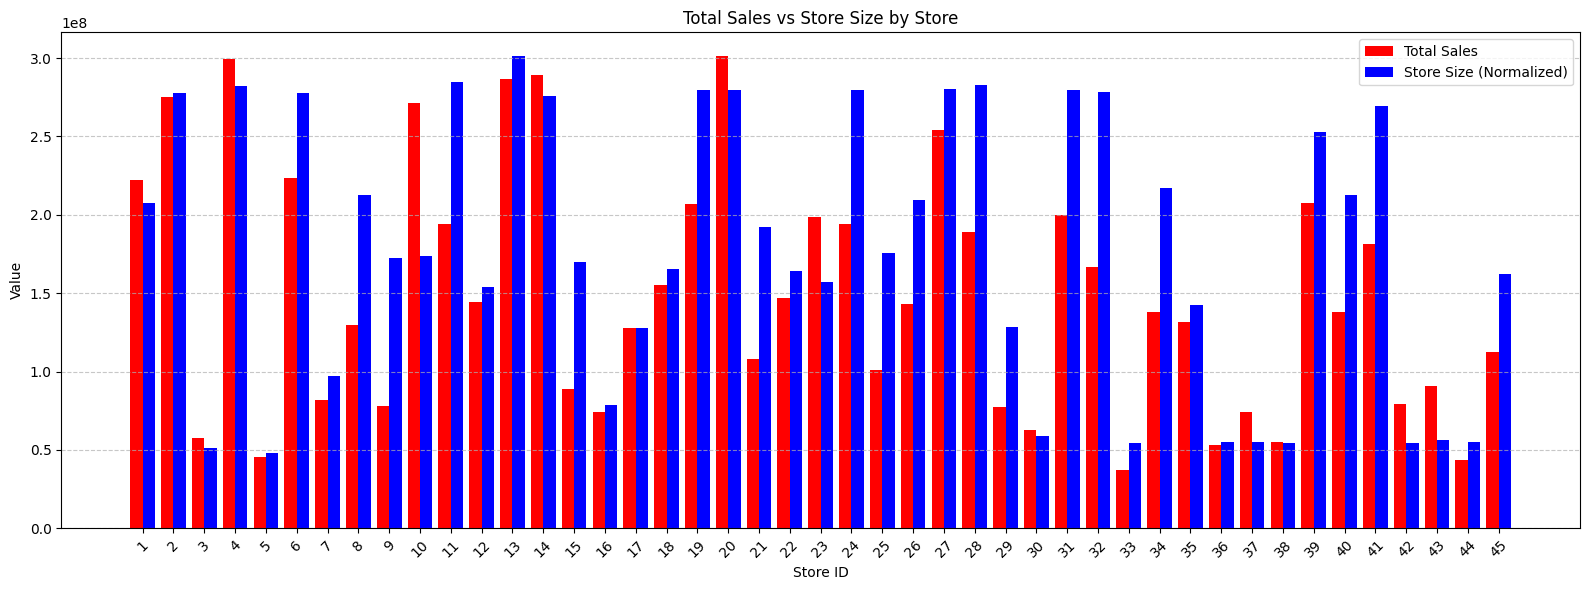

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Aggregate and sort store data
store_size_summary = final_df.groupby('store')['Size'].mean().reset_index()
store_summary_sorted = store_summary.sort_values('Store').reset_index(drop=True)
store_size_summary_sorted = store_size_summary.sort_values('store').reset_index(drop=True)

# Normalize Store Size for better visualization
store_size_summary_sorted['Size'] = store_size_summary_sorted['Size'] / store_size_summary_sorted['Size'].max() * store_summary_sorted['Total_Sales'].max()

# Define x positions
x = np.arange(len(store_summary_sorted['Store']))
width = 0.4

plt.figure(figsize=(16, 6))

# bar plots
plt.bar(x, store_summary_sorted['Total_Sales'], width=width, color='red', label='Total Sales')
plt.bar(x + width, store_size_summary_sorted['Size'], width=width, color='blue', label='Store Size (Normalized)')

# Labels and title
plt.xlabel('Store ID')
plt.ylabel('Value')
plt.xticks(x + width / 2, store_summary_sorted['Store'], rotation=45)
plt.title('Total Sales vs Store Size by Store')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


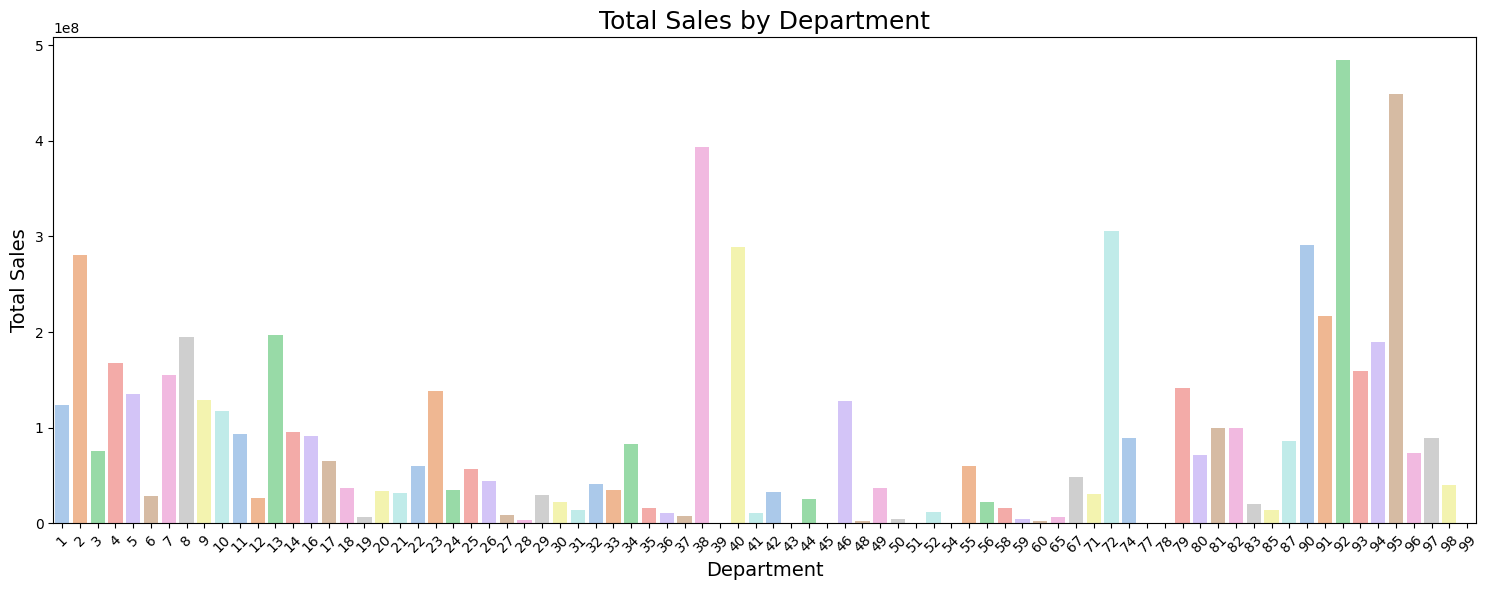

In [ ]:
# Create a bar chart for total sales by department
filtered_dept_summary = dept_summary[dept_summary['Total_Sales'] > 0]
plt.figure(figsize=(15, 6))
sns.barplot(x='Dept', y='Total_Sales', hue='Dept', data=filtered_dept_summary, palette='pastel', legend=False)
plt.title('Total Sales by Department', fontsize=18)
plt.xlabel('Department', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The code groups the sales by department, calculates the total sales for each department, and adjusts these figures into a more digestible form (in tens of thousands). After identifying the top 10 departments by sales, it visualizes them in a horizontal bar chart, labeling its axes and including a title for clarity.

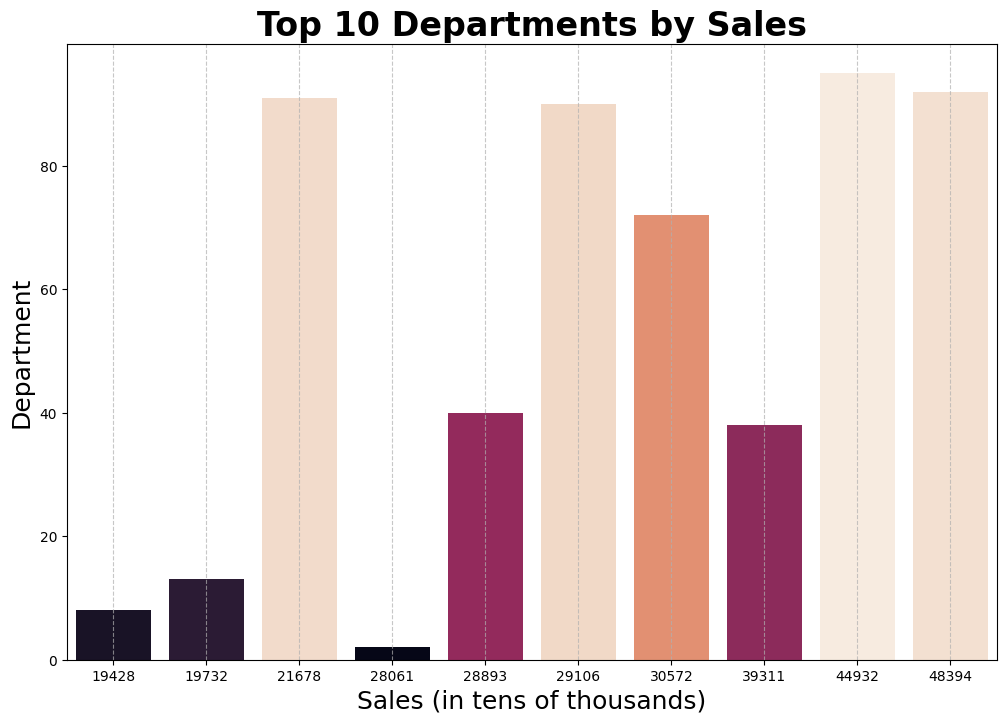

In [ ]:
# Identify which store has the maximum and minimum sales by department
data_Dept = final_df.groupby("department")['sales'].sum().reset_index()
data_Dept['sales'] = (data_Dept['sales'] / 10000).astype(int)

# Sort the data and filter for the top N departments
top_n = 10
data_Dept = data_Dept.sort_values(by='sales', ascending=False).head(top_n)

# Create a horizontal bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='sales', y='department', hue='department', data=data_Dept, palette='rocket', legend=False)
plt.title(f"Top {top_n} Departments by Sales", fontsize=24, fontweight='bold')
plt.xlabel("Sales (in tens of thousands)", fontsize=18)
plt.ylabel("Department", fontsize=18)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### 10. **Store-Level Sales Analysis**
- **Heatmap**: A heatmap displays sales by store and department, helping visualize which store-department combinations perform better.

Analyze sales data by department and store, specifically identifying the combination with the highest and lowest sales:

The code filters out any negative sales values before repeated calculations for minimum sales. Subsequently, it creates a visual representation of total sales using a heatmap to facilitate comparisons between different stores and departments.

Store with maximum sales by department:
 store               14.00
department          92.00
sales         26101497.71
Name: 1057, dtype: float64

Store with minimum sales by department:
 store           35.00
department      47.00
sales        -3567.18
Name: 2623, dtype: float64

Store with minimum sales by department:
 store          9.0
department    78.0
sales          0.0
Name: 663, dtype: float64


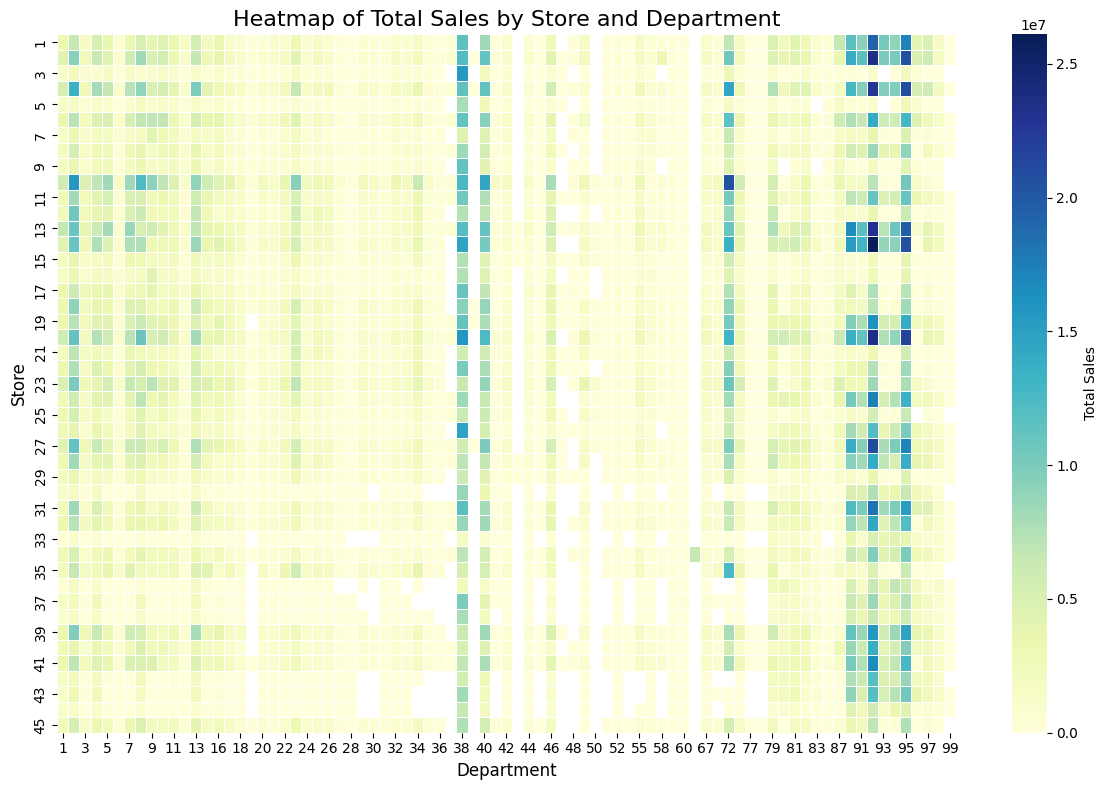

In [ ]:
# Visualizing maximum and minimum sales by department
store_sales_dept = final_df.groupby(['store', 'department'])['sales'].sum().reset_index()
max_sales_store = store_sales_dept.loc[store_sales_dept['sales'].idxmax()]
min_sales_store = store_sales_dept.loc[store_sales_dept['sales'].idxmin()]

print("Store with maximum sales by department:\n", max_sales_store)
print("\nStore with minimum sales by department:\n", min_sales_store)

# Exclude negative sales before finding the minimum
store_sales_dept = store_sales_dept[store_sales_dept['sales'] >= 0]
if not store_sales_dept.empty:
  min_sales_store = store_sales_dept.loc[store_sales_dept['sales'].idxmin()]
  print("\nStore with minimum sales by department:\n", min_sales_store)

# Visualizing total sales by store and department using a heatmap
plt.figure(figsize=(12, 8))
pivot_data = store_sales_dept.pivot(index="store", columns="department", values="sales")
sns.heatmap(pivot_data, cmap="YlGnBu", linewidths=.5, annot=False, cbar_kws={'label': 'Total Sales'})
plt.title('Heatmap of Total Sales by Store and Department', fontsize=16)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Store', fontsize=12)
plt.tight_layout()
plt.show()

### 11. **Holiday Sales Impact**
If the column `IsHoliday_x` exists, the code computes correlations between sales and holidays. It also compares sales on holidays vs non-holidays using bar and box plots.

Analyze the Relationship Between Holiday Status & Sales Data:

The code calculates the correlation between sales and whether a date is a holiday. It also computes and visualizes average sales for holidays and non-holidays through bar plots and box plots, highlighting differences in sales patterns. Additionally, it examines weekly sales trends over time, further illustrating how holidays might influence sales figures.

Correlation between Is_Holiday and sales: 0.0128

Average sales on holidays vs non-holidays:
    IsHoliday_x         sales
0        False  15901.445069
1         True  17035.823187


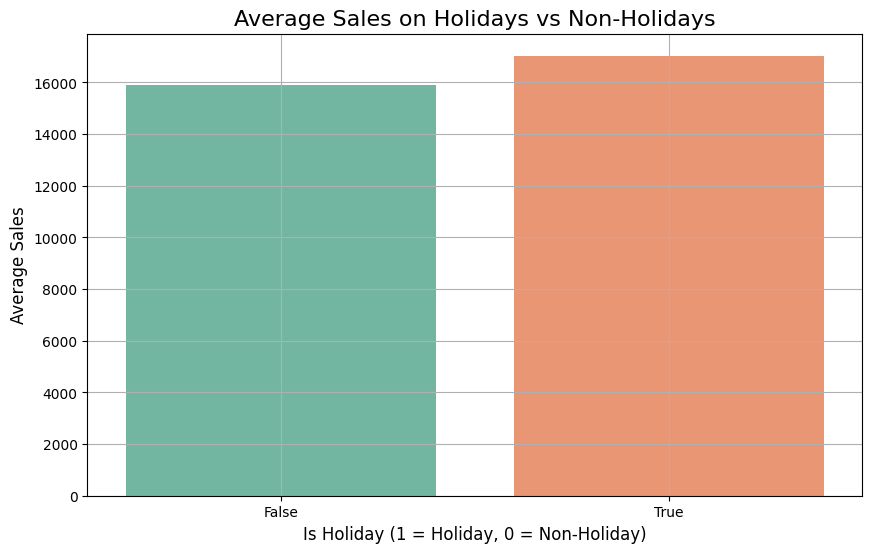

In [ ]:
"""Analyze correlation between sales and the Is_Holiday feature."""
correlation = final_df[['sales', 'IsHoliday_x']].corr().loc['IsHoliday_x', 'sales']
print(f"Correlation between Is_Holiday and sales: {correlation:.4f}")

# Calculate average sales during holidays and non-holidays
holiday_sales_avg = final_df.groupby('IsHoliday_x')['sales'].mean().reset_index()
print("\nAverage sales on holidays vs non-holidays:\n", holiday_sales_avg)

# Visualizing average sales during holidays and non-holidays
plt.figure(figsize=(10, 6))
sns.barplot(x='IsHoliday_x', y='sales', data=final_df, estimator=np.mean, errorbar=None, hue='IsHoliday_x', palette='Set2', legend=False)
plt.title('Average Sales on Holidays vs Non-Holidays', fontsize=16)
plt.xlabel('Is Holiday (1 = Holiday, 0 = Non-Holiday)', fontsize=12)
plt.ylabel('Average Sales', fontsize=12)
plt.grid(True)
plt.show()

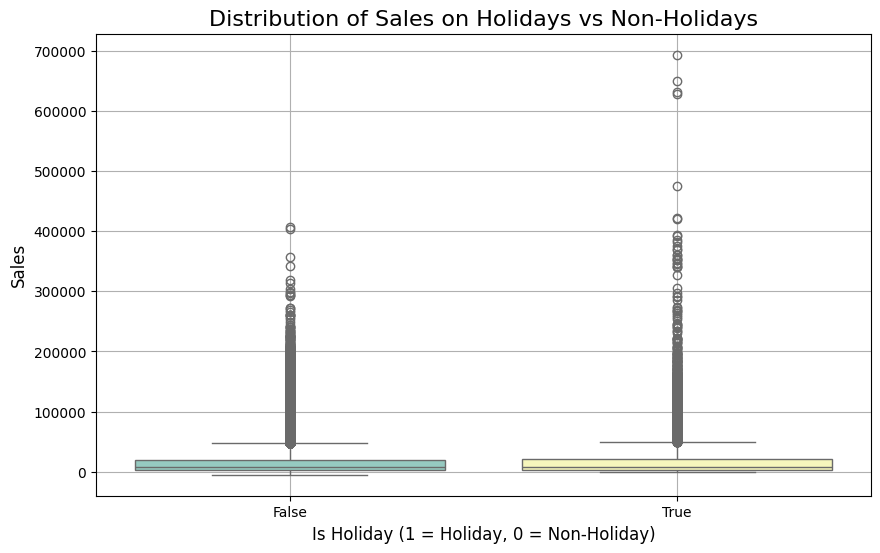

In [ ]:
# Box plot to show distribution of sales on holidays vs non-holidays
plt.figure(figsize=(10, 6))
sns.boxplot(x='IsHoliday_x', y='sales', hue='IsHoliday_x', data=final_df, palette='Set3', legend=False)
plt.title('Distribution of Sales on Holidays vs Non-Holidays', fontsize=16)
plt.xlabel('Is Holiday (1 = Holiday, 0 = Non-Holiday)', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(True)
plt.show()

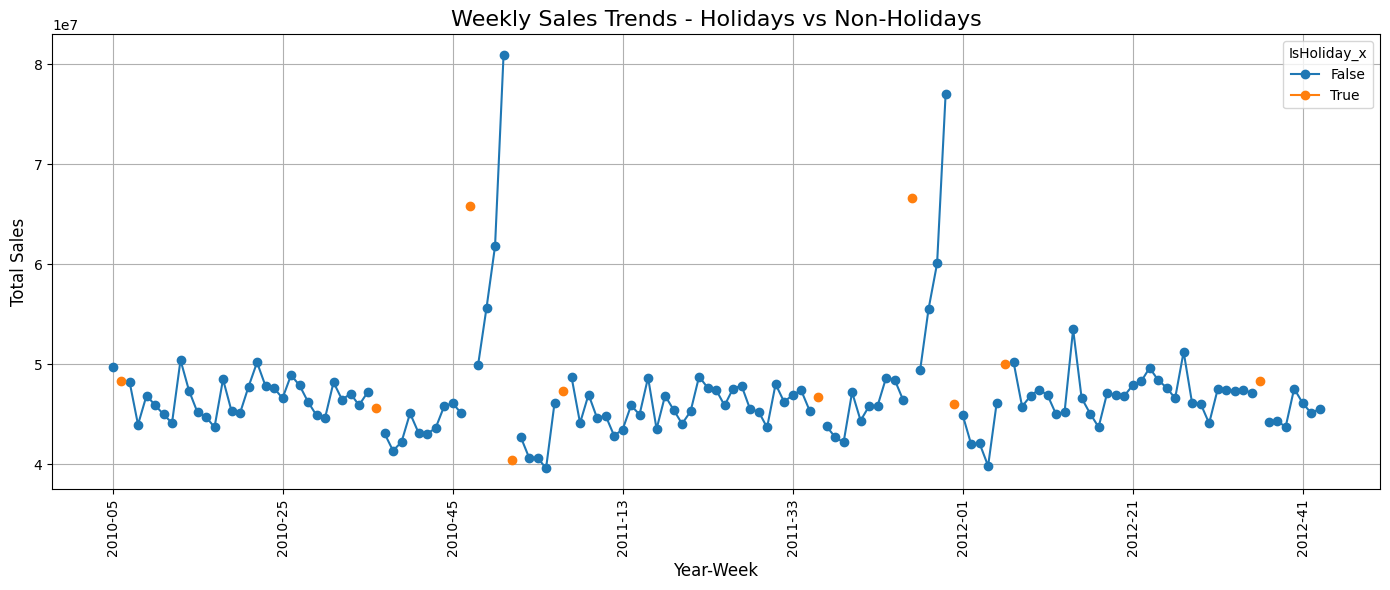

In [ ]:
# Line plot for sales trends over time, highlighting holidays
plt.figure(figsize=(14, 6))
final_df['year_week'] = final_df['date'].dt.strftime('%Y-%W')
weekly_sales = final_df.groupby(['year_week', 'IsHoliday_x'])['sales'].sum().unstack()
weekly_sales.plot(ax=plt.gca(), marker='o')
plt.title('Weekly Sales Trends - Holidays vs Non-Holidays', fontsize=16)
plt.xlabel('Year-Week', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 12. **Correlation Matrix**
A correlation matrix is calculated for numerical features with sales to determine how other variables are related to sales. The matrix is visualized using a heatmap.

Analyze the Data Types of Columns:

The code distinguishes between numerical and categorical columns, performing a correlation analysis specifically to uncover the relationship between various numerical features and sales. A correlation matrix is generated to visually represent these relationships, making it easy to identify which numerical features are most relevant to sales performance. The heatmap improves interpretability by clearly showing both strong and weak correlations amongst the involved features.

Numerical Columns: ['store', 'department', 'sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
Categorical Columns: ['Type', 'Size_Category', 'year_week']

Correlation Matrix with Sales:
sales           1.000000
Size            0.243828
department      0.148032
Fuel_Price     -0.000120
Temperature    -0.002312
CPI            -0.020921
Unemployment   -0.025864
store          -0.085195
Name: sales, dtype: float64


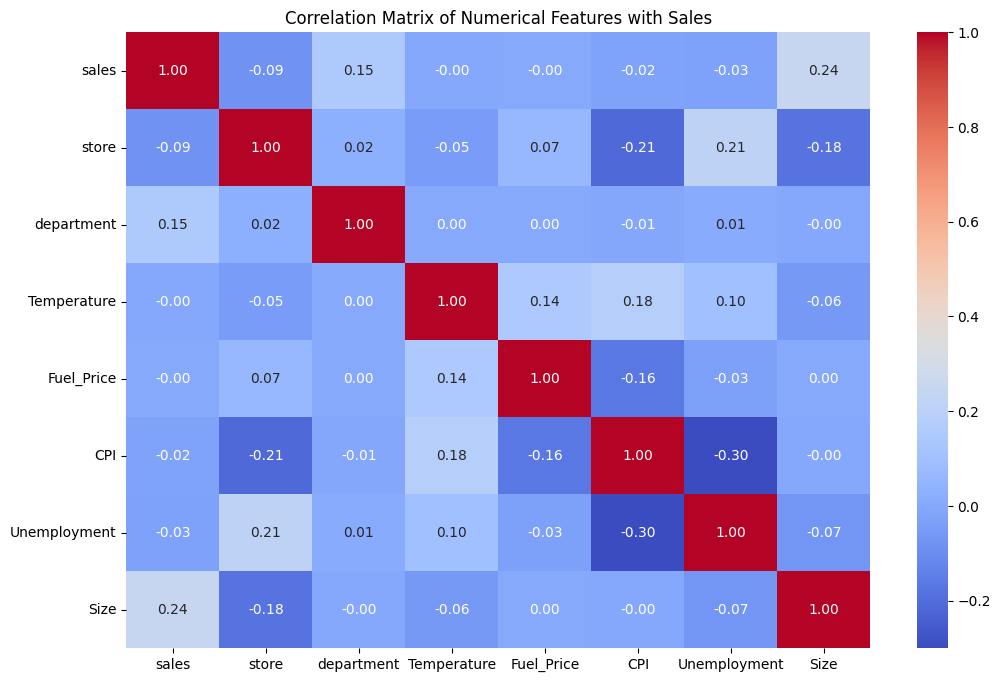

In [ ]:
# Identify numerical and categorical columns
numerical_columns = final_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = final_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical Columns:", numerical_columns)
print("Categorical Columns:", categorical_columns)

# Perform correlation analysis between numerical columns and sales
# Exclude 'sales' itself from the correlation calculation
numerical_columns_ex_sales = [col for col in numerical_columns if col != 'sales']
correlation_matrix = final_df[['sales'] + numerical_columns_ex_sales].corr()

# Display the correlation matrix
print("\nCorrelation Matrix with Sales:")
print(correlation_matrix['sales'].sort_values(ascending=False))

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features with Sales')
plt.show()

### 13. **Categorical Sales Analysis**
For categorical columns, the code computes the average sales by category and visualizes the results using bar plots. This is useful for understanding how categorical features like department or store type affect sales.

Analyze & Visualize Average Sales Data Grouped by Various Categorical Columns:

The code iterates through each categorical column, computes the mean sales for each category, and generates bar plots that clearly illustrate the average sales associated with each category. This provides insights into sales performance across different segments such as departments or store types, making it easier to identify trends and patterns in the sales data.


Average sales by Type:
Type
A    20099.568043
B    12237.075977
C     9519.532538
Name: sales, dtype: float64


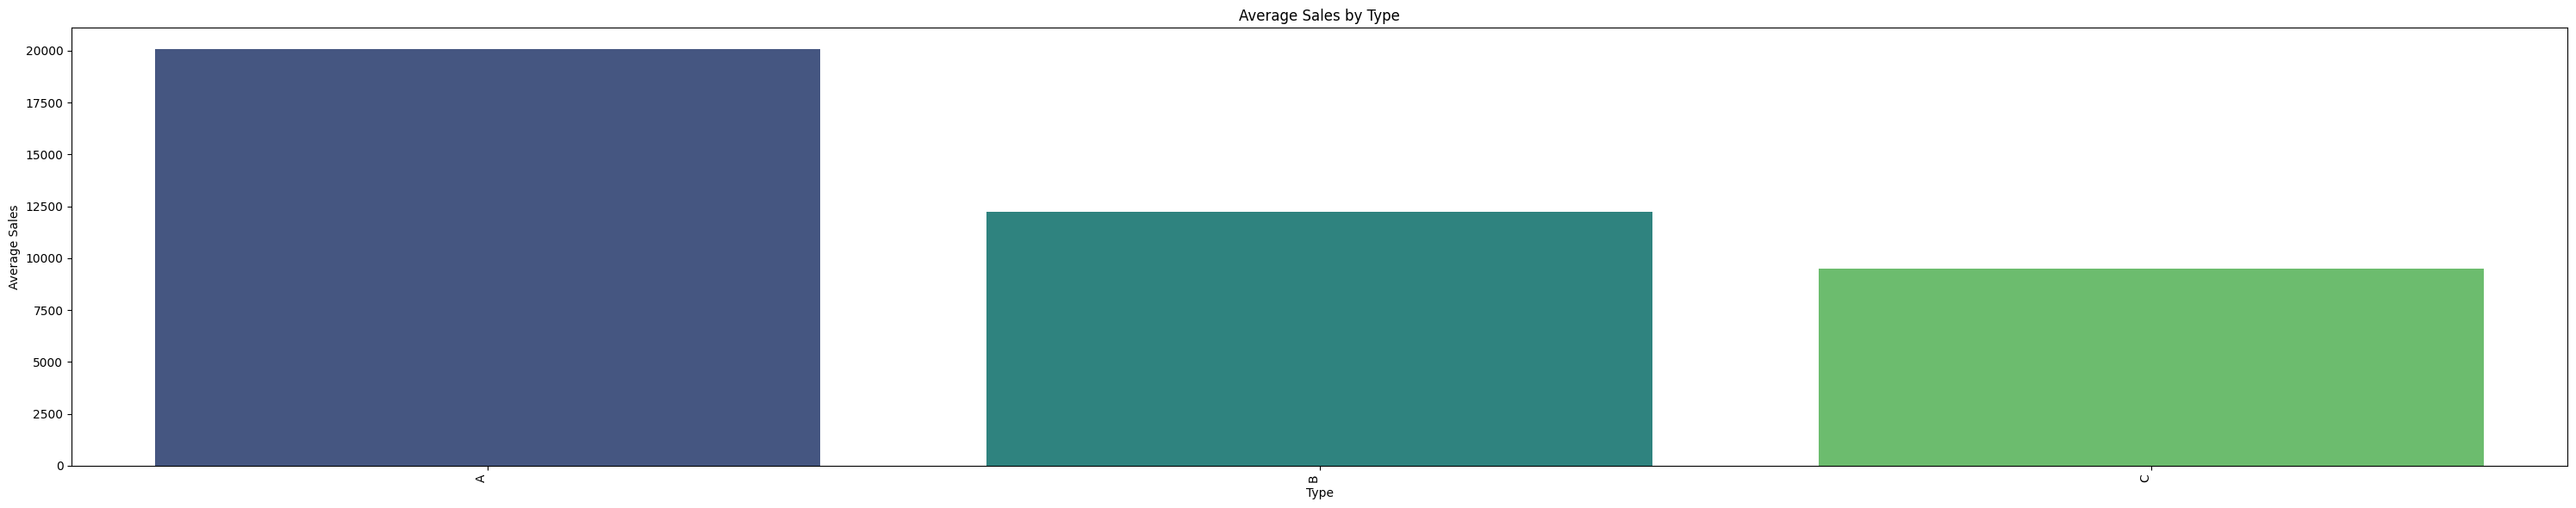


Average sales by Size_Category:
Size_Category
Large    18181.743271
Small     8157.987260
Name: sales, dtype: float64


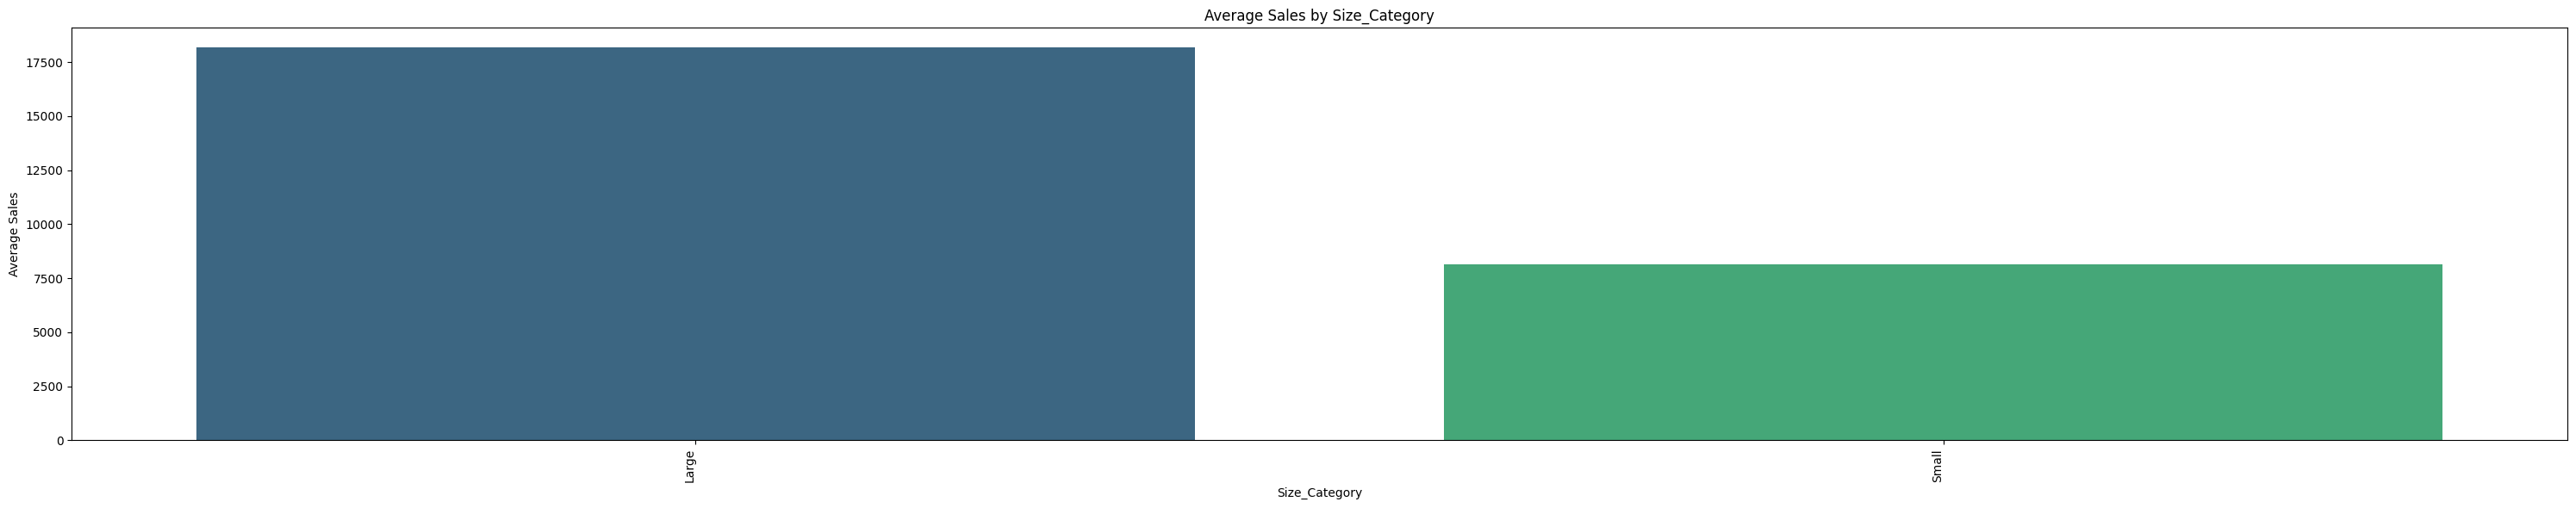


Average sales by year_week:
year_week
2010-51    27378.692693
2011-51    25437.146122
2010-47    22403.336705
2011-47    22043.563476
2010-50    20892.463619
               ...     
2011-03    13932.367385
2011-02    13891.283484
2010-52    13738.538566
2011-04    13566.239462
2012-04    13494.232612
Name: sales, Length: 143, dtype: float64


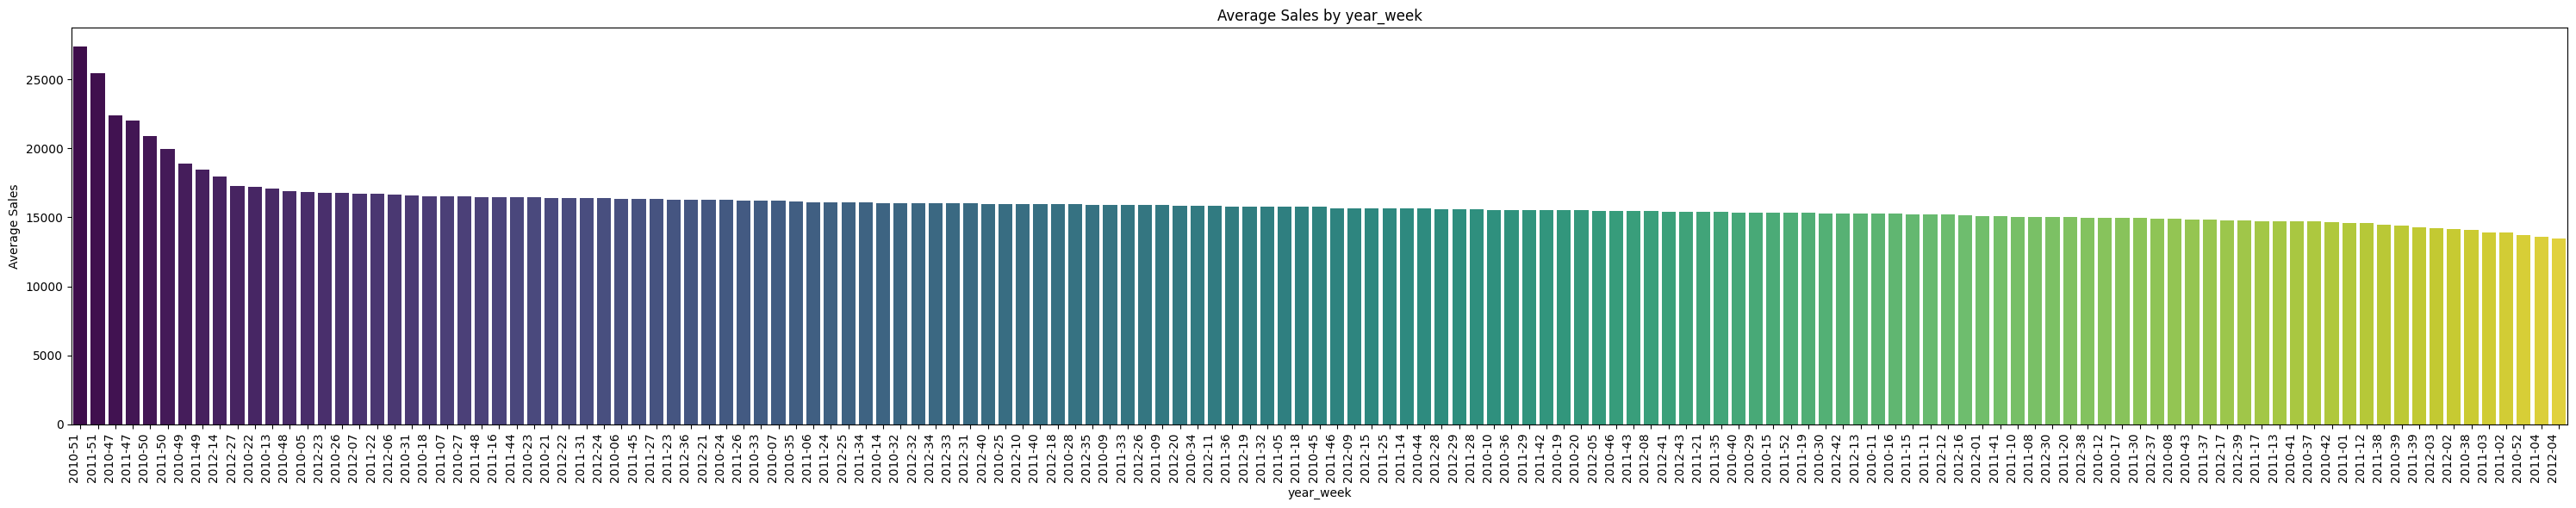

In [ ]:
# Analyze categorical columns to plot average sales by category
for col in categorical_columns:
    """Calculate and plot average sales by categorical column."""
    avg_sales_by_category = final_df.groupby(col)['sales'].mean().sort_values(ascending=False)
    print(f"\nAverage sales by {col}:")
    print(avg_sales_by_category)

    # Plot the average sales for each category
    plt.figure(figsize=(30, 6))
    sns.barplot(x=avg_sales_by_category.index, y=avg_sales_by_category.values, hue=avg_sales_by_category.index, palette='viridis', legend=False)
    plt.title(f'Average Sales by {col}')
    plt.xlabel(col)
    plt.ylabel('Average Sales')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

### 14. **Time Series Decomposition**
At the end, the code prepares for time series decomposition.


Time Series Analysis:

1. **Time Series Preparation**: It sets a datetime index for the sales data, allowing for chronological manipulation.
2. **Sales Aggregation**: It aggregates daily sales into a time series format by summing sales per date.
3. **Seasonal Decomposition**: The code decomposes the time series into trend, seasonal, and residual components to analyze patterns over time. This helps to understand how sales change on a seasonal basis.
4. **Smoothing with Moving Averages**: A 4-week moving average is calculated to smooth out short-term fluctuations, making long-term trends clearer.
5. **Autocorrelation Analysis**: The ACF and PACF plots help assess the relationship of current sales with past sales, guiding any predictive modeling efforts.

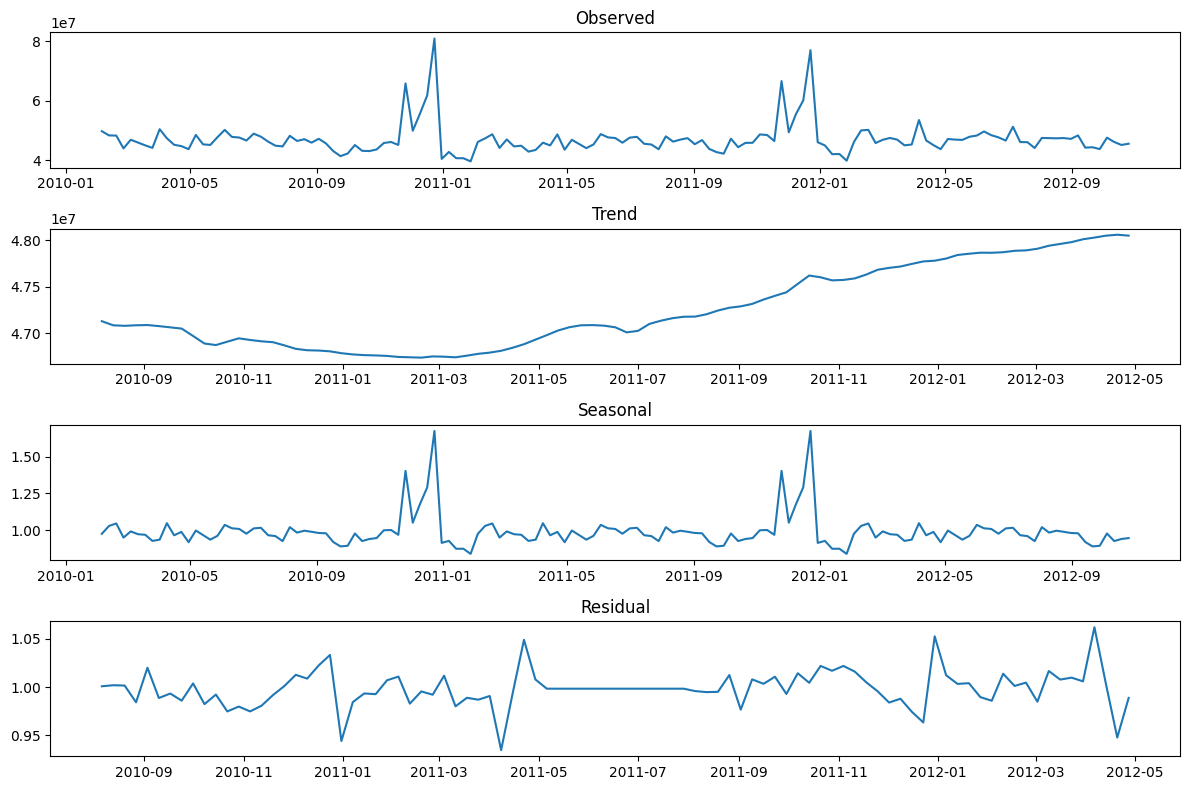

In [ ]:
# Decompose into trend, seasonal, and residual components
decomposition = seasonal_decompose(store_sales, model='multiplicative', period=52)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
components = ['Observed', 'Trend', 'Seasonal', 'Residual']
series = [store_sales, decomposition.trend, decomposition.seasonal, decomposition.resid]

for ax, component, data in zip(axes, components, series):
    ax.plot(data)
    ax.set_title(component)

plt.tight_layout()
plt.show()

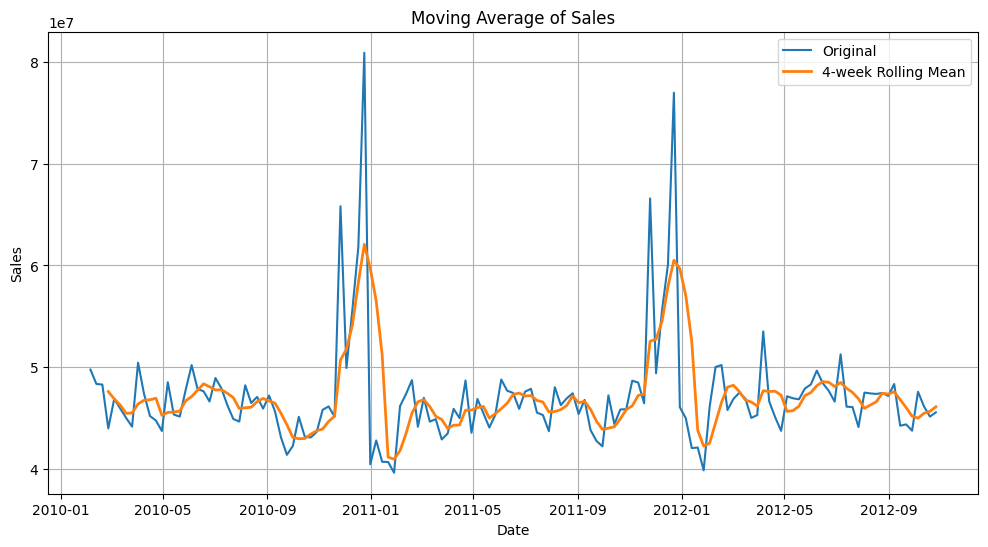

In [ ]:
# Calculate and plot a moving average for the sales time series
store_sales_rolling = store_sales.rolling(window=4).mean()

plt.figure(figsize=(12, 6))
plt.plot(store_sales, label='Original')
plt.plot(store_sales_rolling, label='4-week Rolling Mean', linewidth=2)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Moving Average of Sales")
plt.grid(True)
plt.show()

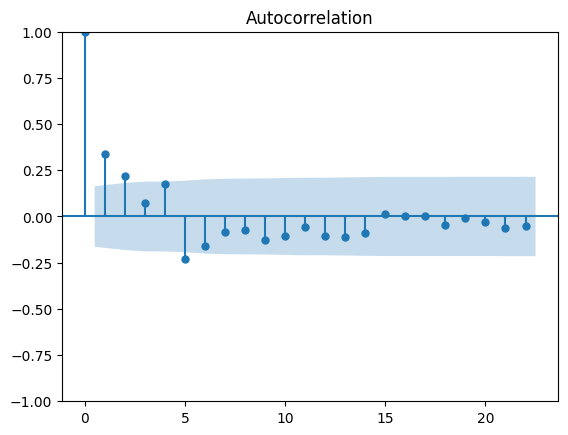

In [ ]:
# Autocorrelation and Partial Autocorrelation
"""Plot ACF and PACF for the sales time series."""
plot_acf(store_sales)
plt.show()

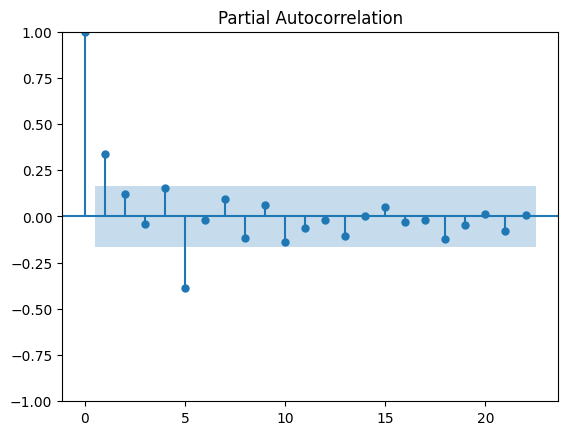

In [ ]:
plot_pacf(store_sales)
plt.show()

The code primarily manipulates the sales dataset by creating lag and lead variables to facilitate time series analysis, followed by a comparative assessment of sales during promotional/national holiday periods versus non-holiday sales.

It further ranks stores by total sales, identifies outliers using the Z-score method and visualizes them, and examines correlations between sales and key economic indicators through a heatmap.

Overall, it prepares the data for more in-depth econometric analysis while providing visual insights into sales dynamics and factors impacting them.

In [ ]:
final_df.columns.str.strip()

Index(['date', 'store', 'department', 'sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size',
       'Size_Category', 'year_week'],
      dtype='object')

In [ ]:
# Stop

In [ ]:
final_df.head(3)

,date,store,department,sales,IsHoliday_x,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_y,Type,Size,Size_Category,year_week
date,,,,,,,,,,,,,,
2010-02-05,2010-02-05,1,1,24924.50,False,42.31,2.572,211.096358,8.106,False,A,151315,Large,2010-05
2010-02-12,2010-02-12,1,1,46039.49,True,38.51,2.548,211.242170,8.106,True,A,151315,Large,2010-06
2010-02-19,2010-02-19,1,1,41595.55,False,39.93,2.514,211.289143,8.106,False,A,151315,Large,2010-07


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


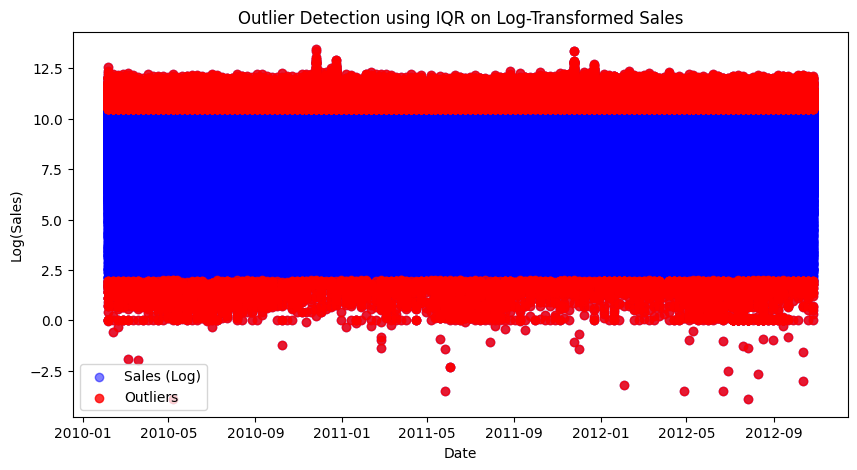

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply log transformation
final_df['sales_log'] = np.log1p(final_df['sales'])

# Compute IQR on log-transformed sales
Q1 = final_df['sales_log'].quantile(0.25)
Q3 = final_df['sales_log'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
upper_bound = Q3 + 0.25 * IQR
lower_bound = Q1 - 2.5 * IQR

# Detect outliers
outliers = final_df[(final_df['sales_log'] > upper_bound) | (final_df['sales_log'] < lower_bound)]

# Filter out outliers
final_df_cleaned = final_df[(final_df['sales_log'] >= lower_bound) & (final_df['sales_log'] <= upper_bound)]

# Plot before and after removing outliers
plt.figure(figsize=(10, 5))

# Original Data with Outliers
plt.scatter(final_df['date'], final_df['sales_log'], label="Sales (Log)", color='blue', alpha=0.5)
plt.scatter(outliers['date'], outliers['sales_log'], color='red', label="Outliers", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Log(Sales)")
plt.title("Outlier Detection using IQR on Log-Transformed Sales")
plt.legend()
plt.show()

In [ ]:
final_df.shape

(421570, 15)

In [ ]:
# Remove outliers based on log-transformed sales
final_df_t = final_df
final_df_t = final_df_t[(final_df_t['sales_log'] >= lower_bound) & (final_df_t['sales_log'] <= upper_bound)]

# Drop the temporary log-transformed column if not needed
final_df_t.drop(columns=['sales_log'], inplace=True)

<ipython-input-347-9d087a798c93>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_t.drop(columns=['sales_log'], inplace=True)


In [ ]:
final_df_t.shape

(360688, 14)

In [ ]:
final_df = final_df_t

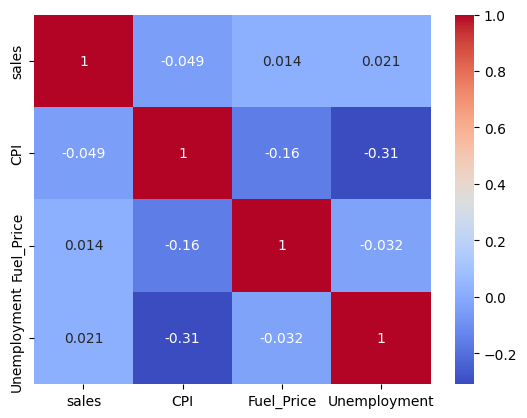

In [ ]:
# Heatmap of correlation with economic indicators
corr_matrix = final_df[['sales', 'CPI', 'Fuel_Price', 'Unemployment']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

 Perform a price sensitivity analysis by examining the relationship between fuel prices & sales figures:

 The code first checks for the existence of a 'Fuel_Price' column in the dataset. If found, it generates a scatter plot to visualize the correlation between sales and fuel prices and calculates the Pearson correlation coefficient, which quantifies this relationship. If the 'Fuel_Price' column is missing, it provides a message indicating that the analysis cannot proceed.

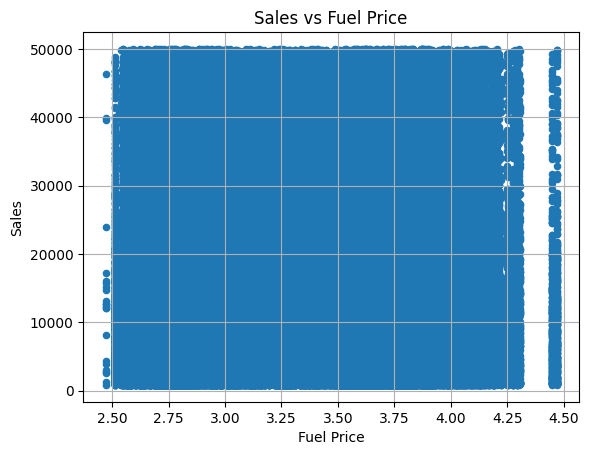

Correlation between Fuel Price and Weekly Sales: 0.0140


In [ ]:
# Price Sensitivity Analysis
if 'Fuel_Price' in final_df.columns:
  """Analyze the correlation between fuel price and sales."""
  final_df.plot.scatter(x='Fuel_Price', y='sales')
  plt.title('Sales vs Fuel Price')
  plt.xlabel('Fuel Price')
  plt.ylabel('Sales')
  plt.grid()
  plt.show()

  # Calculate and display correlation
  correlation = final_df['sales'].corr(final_df['Fuel_Price'])
  print(f'Correlation between Fuel Price and Weekly Sales: {correlation:.4f}')
else:
  print("Fuel_Price column is missing from the DataFrame.")

Analyze & Visualize the Impact of Holidays:

The code begins by ensuring that the `date` column does not cause redundancy and resets the DataFrame index for clarity and structure. It then checks for the existence of a column indicating holidays (`IsHoliday_x`), and if present, computes and plots the average sales on holidays and non-holidays over time.

The visual representation aids in understanding the sales trends relative to holiday periods. If the required column is missing, it appropriately informs the user, ensuring robustness in execution.

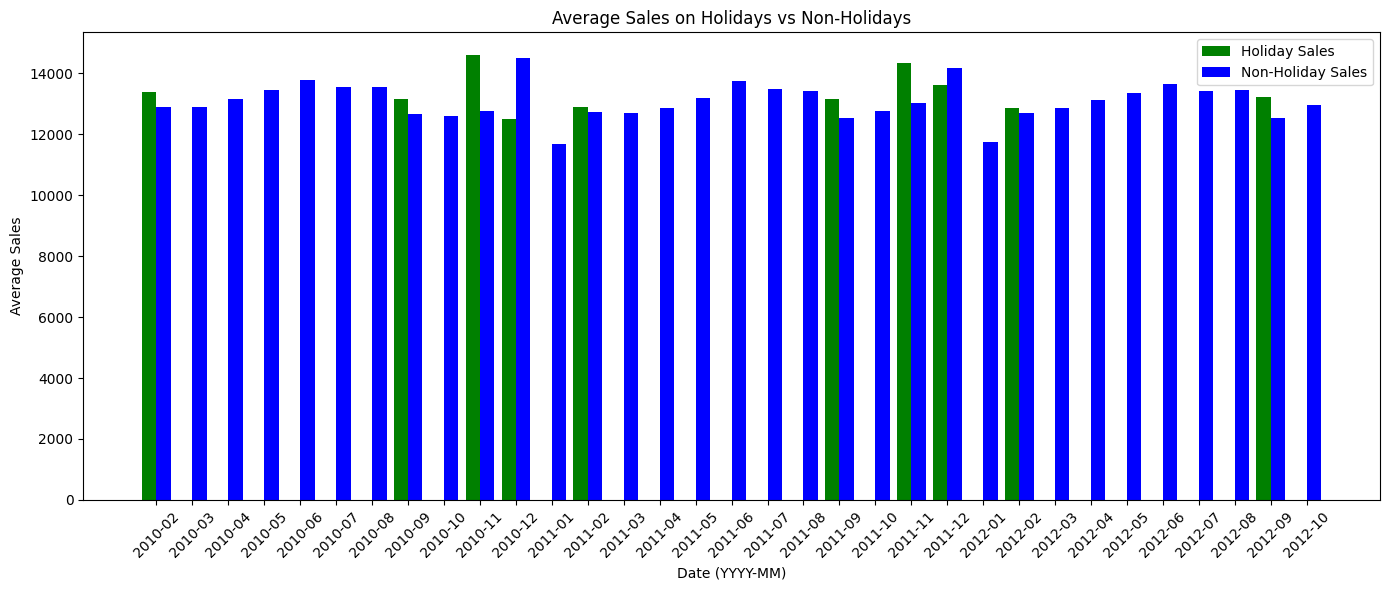

In [ ]:
# Convert 'date' to YYYY-MM format
final_df_reset = final_df.reset_index(drop=True)
final_df_reset['date'] = pd.to_datetime(final_df_reset['date']).dt.strftime('%Y-%m')

# Aggregate sales data
if 'IsHoliday_x' in final_df_reset.columns:
    holiday_sales = final_df_reset[final_df_reset['IsHoliday_x']].groupby('date')['sales'].mean()
    non_holiday_sales = final_df_reset[~final_df_reset['IsHoliday_x']].groupby('date')['sales'].mean()

    # Align indexes by reindexing both Series to the same date range
    all_dates = sorted(set(holiday_sales.index) | set(non_holiday_sales.index))
    holiday_sales = holiday_sales.reindex(all_dates, fill_value=0)
    non_holiday_sales = non_holiday_sales.reindex(all_dates, fill_value=0)

    # Plotting holiday vs non-holiday sales as a bar chart
    plt.figure(figsize=(14, 6))
    x = range(len(all_dates))
    width = 0.4

    plt.bar(x, holiday_sales, width=width, label='Holiday Sales', color='green', align='center')
    plt.bar([i + width for i in x], non_holiday_sales, width=width, label='Non-Holiday Sales', color='blue', align='center')

    plt.xticks([i + width / 2 for i in x], all_dates, rotation=45)
    plt.title('Average Sales on Holidays vs Non-Holidays')
    plt.xlabel('Date (YYYY-MM)')
    plt.ylabel('Average Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("IsHoliday_x column is missing from the DataFrame.")


#Removing Multicollinearity in Numerical Variables using VIF

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Selecting only numerical features (excluding target 'sales')
numerical_features = final_df.select_dtypes(include=[np.number]).drop(columns=['sales'])

# Dropping rows with NaN or Infinite values
numerical_features = numerical_features.replace([np.inf, -np.inf], np.nan).dropna()

# Calculating VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = numerical_features.columns
vif_data['VIF'] = [variance_inflation_factor(numerical_features.values, i) for i in range(len(numerical_features.columns))]

# Display VIF values
print(vif_data)


        Feature        VIF
0         store   4.363462
1    department   3.076239
2   Temperature  12.900796
3    Fuel_Price  32.950522
4           CPI  16.063119
5  Unemployment  17.015658
6          Size   6.775908
7     sales_log  18.707034


In [ ]:
# Dropping high VIF features (Fuel_Price, CPI, Unemployment, Temperature)
high_vif_features = ["Fuel_Price", "Unemployment", "CPI"]
numerical_features = numerical_features.drop(columns=high_vif_features)

# Recalculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = numerical_features.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_features.values, i) for i in range(len(numerical_features.columns))]

# Display updated VIF values
print(vif_data)


       Feature       VIF
0        store  3.281035
1   department  2.732081
2  Temperature  6.036027
3         Size  4.829544


#Remove multicollinearity in categorical variables with annova.

In [ ]:
# Extract categorical features
categorical_features = final_df.select_dtypes(include=['object', 'category'])

# Perform ANOVA and collect p-values
import statsmodels.api as sm

p_values = {}
for col in categorical_features.columns:
    model = sm.OLS(final_df['sales'], pd.get_dummies(final_df[col], drop_first=True)).fit()
    p_values[col] = model.pvalues.max()

# Display p-values
print(pd.DataFrame(p_values.items(), columns=['Feature', 'Max P-Value']))


         Feature  Max P-Value
0           Type          0.0
1  Size_Category          0.0
2      year_week          0.0


#Spliiting df into training and testing data

In [ ]:
final_df['sales'] = np.where(final_df['sales'] <= 0, 1e-8, final_df['sales'])

final_df['sales_log'] = np.log1p(final_df['sales'])

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Selected features
final_features = numerical_features.columns.tolist()

# Target variable (changed to sales_log)
y = final_df['sales_log']

# Create the feature matrix X using the final_features
X = final_df[final_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display final feature set
print(f"Final feature set:\n{X.columns.tolist()}")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Final feature set:
['store', 'department', 'Temperature', 'Size']
Training set shape: (224863, 4)
Test set shape: (96371, 4)


#Applying Linear Regression

In [ ]:
def evaluate_model(y_true, y_pred):
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Calculate MAPE
    mape = np.mean(np.abs((np.expm1(y_true) - np.expm1(y_pred)) / np.expm1(y_true)))

    # Calculate SMAPE
    smape = np.mean(2 * np.abs(np.expm1(y_true) - np.expm1(y_pred)) /
                    (np.abs(np.expm1(y_true)) + np.abs(np.expm1(y_pred))))

    # Print results
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R2): {r2}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
    print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}")

    return mse, rmse, r2, mape, smape

In [ ]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model on scaled data
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse, rmse, r2, mape, smape = evaluate_model(y_test, y_pred)

Mean Squared Error (MSE): 1.0281303066115242
Root Mean Squared Error (RMSE): 1.013967606292984
R-squared (R2): 0.02540423070126141
Mean Absolute Percentage Error (MAPE): 1.21
Symmetric Mean Absolute Percentage Error (SMAPE): 0.75


In [ ]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Evaluate the model
mse_ridge, rmse_ridge, r2_ridge, mape_ridge, smape_ridge = evaluate_model(y_test, y_pred_ridge)

Mean Squared Error (MSE): 1.028130303779406
Root Mean Squared Error (RMSE): 1.0139676048964317
R-squared (R2): 0.02540423338591158
Mean Absolute Percentage Error (MAPE): 1.21
Symmetric Mean Absolute Percentage Error (SMAPE): 0.75


In [ ]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Evaluate the model
mse_ridge, rmse_ridge, r2_ridge, mape_ridge, smape_ridge = evaluate_model(y_test, y_pred_ridge)

Mean Squared Error (MSE): 1.028130303779406
Root Mean Squared Error (RMSE): 1.0139676048964317
R-squared (R2): 0.02540423338591158
Mean Absolute Percentage Error (MAPE): 1.21
Symmetric Mean Absolute Percentage Error (SMAPE): 0.75


#Plot residual and fitted graph.

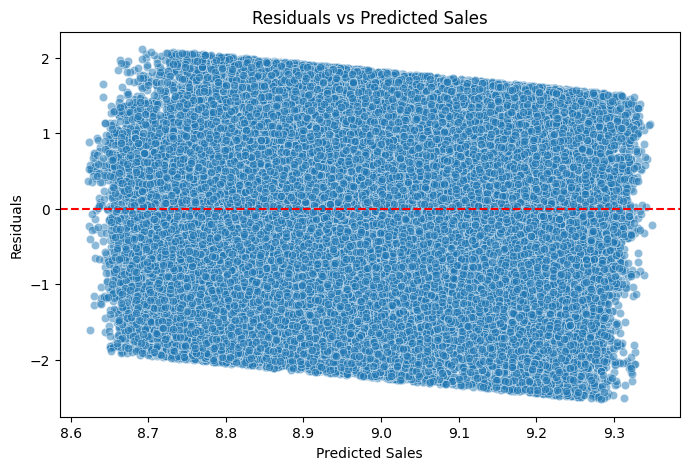

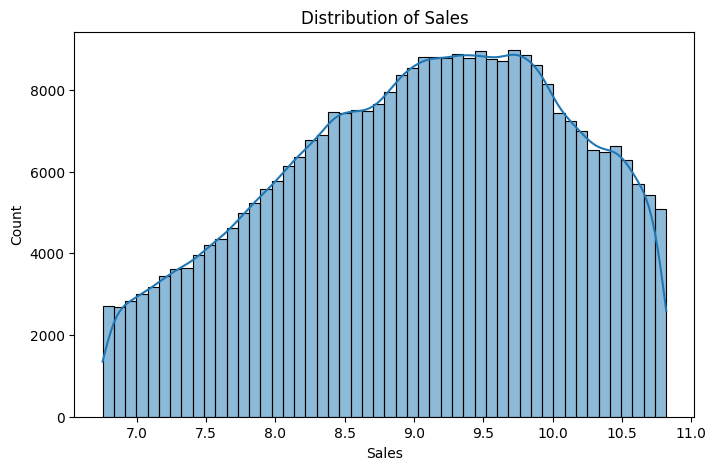

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Sales')
plt.show()

# Check distribution of sales
plt.figure(figsize=(8, 5))
sns.histplot(y, bins=50, kde=True)
plt.xlabel('Sales')
plt.title('Distribution of Sales')
plt.show()


In [ ]:
final_df.to_csv("final_df.csv", index=False)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the Decision Tree model
model = DecisionTreeRegressor(max_depth=11, random_state=42, min_samples_split = 50, min_samples_leaf=50)

# Train the model
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse, rmse, r2, mape, smape = evaluate_model(y_test, y_pred)

Mean Squared Error (MSE): 0.16042918017327656
Root Mean Squared Error (RMSE): 0.4005361159412177
R-squared (R2): 0.8479243348207046
Mean Absolute Percentage Error (MAPE): 0.31
Symmetric Mean Absolute Percentage Error (SMAPE): 0.27


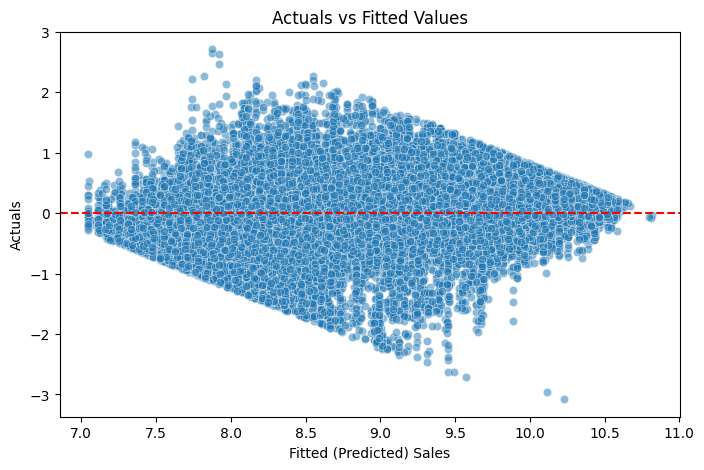

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Reference line at 0
plt.xlabel('Fitted (Predicted) Sales')
plt.ylabel('Actuals')
plt.title('Actuals vs Fitted Values')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define the improved model
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Train the model
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse, rmse, r2, mape, smape = evaluate_model(y_test, y_pred)

Mean Squared Error (MSE): 0.14418021822255692
Root Mean Squared Error (RMSE): 0.3797107033289382
R-squared (R2): 0.8633272166060494
Mean Absolute Percentage Error (MAPE): 0.29
Symmetric Mean Absolute Percentage Error (SMAPE): 0.26


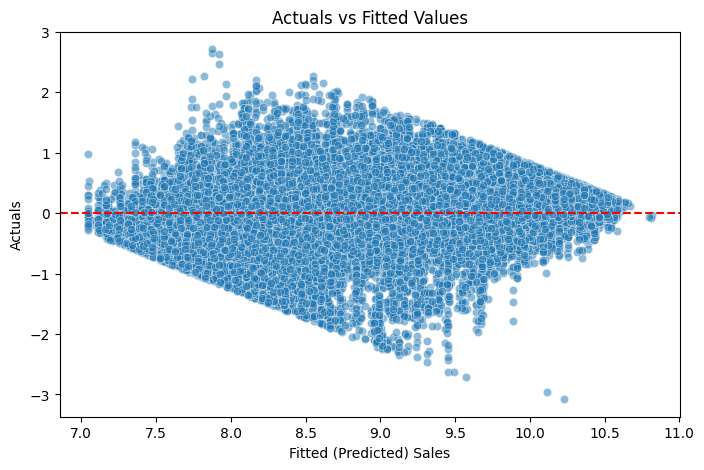

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Reference line at 0
plt.xlabel('Fitted (Predicted) Sales')
plt.ylabel('Actuals')
plt.title('Actuals vs Fitted Values')
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the model with optimized parameters
model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)

# Train the model
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse, rmse, r2, mape, smape = evaluate_model(y_test, y_pred)


Mean Squared Error (MSE): 0.2006721940975471
Root Mean Squared Error (RMSE): 0.4479645009345574
R-squared (R2): 0.809776766499636
Mean Absolute Percentage Error (MAPE): 0.38
Symmetric Mean Absolute Percentage Error (SMAPE): 0.32


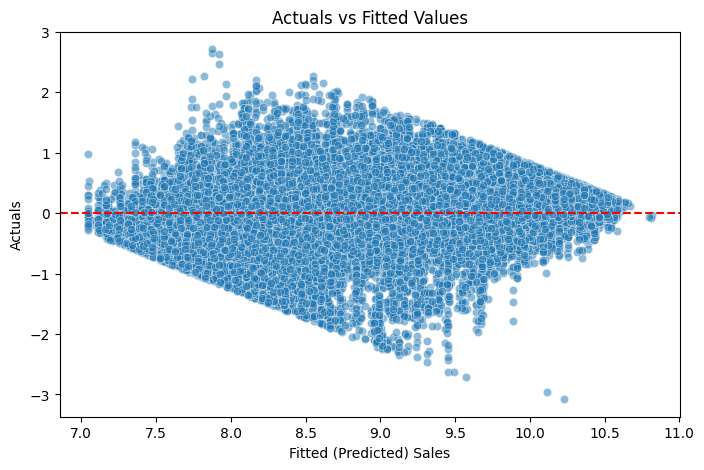

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Reference line at 0
plt.xlabel('Fitted (Predicted) Sales')
plt.ylabel('Actuals')
plt.title('Actuals vs Fitted Values')
plt.show()

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

# Define the model with optimized parameters
model = ExtraTreesRegressor(
    n_estimators=200,
    max_depth=11,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

# Train the model
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse, rmse, r2, mape, smape = evaluate_model(y_test, y_pred)


Mean Squared Error (MSE): 0.21224567065349445
Root Mean Squared Error (RMSE): 0.46070128136732424
R-squared (R2): 0.7988059185293249
Mean Absolute Percentage Error (MAPE): 0.39
Symmetric Mean Absolute Percentage Error (SMAPE): 0.34


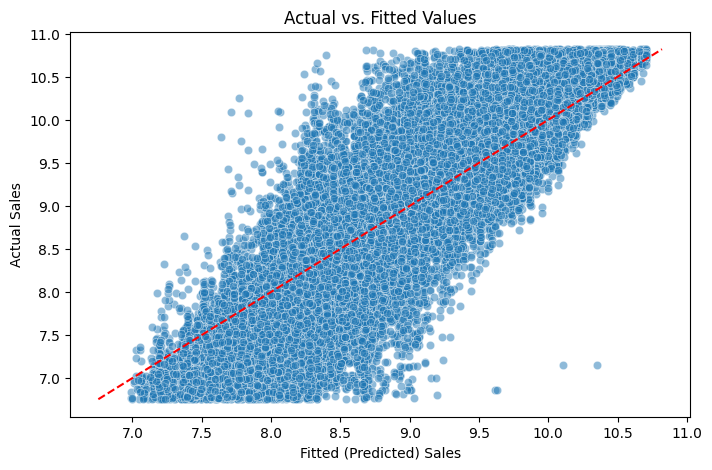

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Actual vs Fitted plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 45-degree reference line
plt.xlabel('Fitted (Predicted) Sales')
plt.ylabel('Actual Sales')
plt.title('Actual vs. Fitted Values')
plt.show()


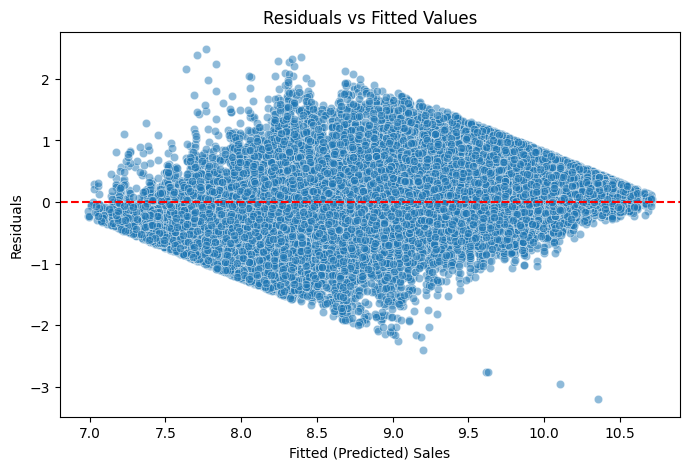

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Reference line at 0
plt.xlabel('Fitted (Predicted) Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

In [ ]:
final_df.head()

,date,store,department,sales,IsHoliday_x,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_y,Type,Size,Size_Category,year_week,sales_log
date,,,,,,,,,,,,,,,
2010-02-05,2010-02-05,1,1,24924.50,False,42.31,2.572,211.096358,8.106,False,A,151315,Large,2010-05,10.123647
2010-02-12,2010-02-12,1,1,46039.49,True,38.51,2.548,211.242170,8.106,True,A,151315,Large,2010-06,10.737277
2010-02-19,2010-02-19,1,1,41595.55,False,39.93,2.514,211.289143,8.106,False,A,151315,Large,2010-07,10.635773
2010-02-26,2010-02-26,1,1,19403.54,False,46.63,2.561,211.319643,8.106,False,A,151315,Large,2010-08,9.873262
2010-03-05,2010-03-05,1,1,21827.90,False,46.50,2.625,211.350143,8.106,False,A,151315,Large,2010-09,9.990990
